In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import pickle
import scipy as sp
from scipy.signal import savgol_filter as savgol
import seaborn as sns
from copy import deepcopy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
npg_colors = ['#00A087FF','#E64B35FF','#3C5488FF',\
         '#4DBBD5FF','#F39B7FFF','#8491B4FF','#91D1C2FF','#DC0000FF','#7E6148FF','#B09C85FF']
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'font.size':25});
plt.rc('lines',linewidth=2);
plt.rcParams.update({'axes.linewidth':1.5})
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

from read_PR_data import PR_2_dicts # PR: plate reader 

In [3]:
# these functions are pretty specific to the plate layout for the 2021 experiments. 
def get_data(fn,nR,nC,sampling_rate):
    '''
    fn: string of the filename from plate reader. It is a text file that the BioTek instruments output 
    The function PR_2_dicts has code to scrape the file and outputs dictionaries with the well IDs as keys
    (Another tip since the code isn't perfect. Read OD first on the reader, then any fluorescence measurements)
    nR: number of rows (best to have the plate reader sample all rows and columns, because PR_2_dicts will 
    consider the first sampled well as A1, the second as A2 row wise.)
    nC: number of columns
    sampling_rate: The sampling time in minutes 
    '''
    data,numReads = PR_2_dicts(fn,nR,nC) 
    tspan = np.linspace(0,numReads*sampling_rate,numReads)/60 # time in hours
    for ii,measurements in enumerate(data): # will need to adjust this loop for new protocols
        if ii == 0: 
            od = measurements
        elif ii == 1: 
            afu1 = measurements
        elif ii == 2: 
            afu2 = measurements
            
    afu_normed = {}
    for key in afu1: 
        afu_normed[key] = afu1[key]/od[key]
        
    return od,afu1,afu_normed,tspan

def gen_well_keys(nR,nC):
    # generate list of well keys for treatment and control and corresponding tags
    import string
    row_keys = list(string.ascii_uppercase[0:nR])
    col_keys = range(1,nC+1)

    from itertools import product
    cartprod = list(product(row_keys,col_keys))

    well_keys = []
    for i in cartprod:
        well_keys.append(str(i[0]+str(i[1])))
        
    return well_keys

def plot_data(X,tspan,labels,conds,nR,nC,figsize,ic=0,addLegend=False,bboxanchor=(1.125,0.75),
              addLabels=False,xLabel='X',yLabel='Y',xPos=[0.5,-0.5],yPos=[-0.5,0.5],
              savefig=False,savedir='/Users/aqib/Desktop/fig.pdf'): 
    '''
    X: dictionary of data with keys as well locations
    labels: dictionary of strain id: well location pairs
    conds: list of experimental conditions
    nR: number of rows for subplots
    nC: number of columns of subplots
    '''

    fig,axs = plt.subplots(nR,nC,figsize=figsize,sharex=True,sharey='row')
    for ii,ax in enumerate(axs.reshape(-1)):
        if ii < len(labels): # this is necessary because we have to generate a full grid of subplots
            strain = list(labels.keys())[ii] # formerly key
            ax.set_title(strain)
            for jj in range(len(conds)): # number of conditions per strain
                ax.plot(tspan[ic:],savgol(X[labels[strain][jj]][ic:],25,1,axis=0)) # data is smoothed while plotting
            for side in ax.spines.keys(): # top, bottom, left, right
                ax.spines[side].set_linewidth(2) # I often like thick spines
    plt.tight_layout();
    if addLabels: 
        fig.text(xPos[0],xPos[1],xLabel,ha='center');
        fig.text(yPos[0],yPos[1],yLabel,va='center',rotation='vertical');
    if addLegend: 
        fig.legend(conds,frameon=False,bbox_to_anchor=bboxanchor)
    if savefig: 
        plt.savefig(savedir,transparent=True,bbox_inches='tight')
    plt.show()
    
def get_titrations(y,labels,conds):
    '''
    y: data dictionary where key-value pair is well locations: plate reader data (e.g. gfpn, gfp, od)
    labels: dictionary of strain id: well location pairs
    conds: list of experimental conditions
    '''
    titration_dict = {} # key-value pairs, strain label: matrix with cols as cond. and rows as time-series
    for strain,val in labels.items():
        tmp = np.zeros((len(conds),len(tspan))) # building matrix of conditions x time for each strain
        for ii in range(len(conds)): # number of conditions for each strain (key) 
            tmp[ii:ii+1,:] = y[labels[strain][ii]].T
        titration_dict[strain] = tmp
        
    titration_mean = {}
    titration_std = {}
    # first get unique strain names (without replicate number)
    strains = list(set([x.split('_')[0] for x in list(titration_dict.keys())]))
    for strain in strains: 
        titration_mean[strain] = np.mean([titration_dict[strain+'_1'],titration_dict[strain+'_2'],
                                          titration_dict[strain+'_3']],axis=0)
        titration_std[strain] = np.std([titration_dict[strain+'_1'],titration_dict[strain+'_2'],
                                          titration_dict[strain+'_3']],axis=0)        
    
    # compute the fold changes for all the strains at all times
    titration_fc = {}
    fc_tmp = np.zeros((len(conds)-1,len(tspan)))
    for strain in strains: 
        for cond in range(len(conds)-1):
            fc_tmp[cond,:] = titration_mean[strain][cond+1,:]/titration_mean[strain][0,:]
        titration_fc[strain] = fc_tmp
        
    return titration_dict, titration_mean, titration_std, titration_fc

def concat_dicts(dict_all, dict_new): 
    '''
    Add the key-value pairs of dict_new to dict_all and return the updated dict_all
    '''
    for strain,val in dict_new.items():
        dict_all[strain] = val
        
    return dict_all


In [4]:
# the universal datasets will contain data of od normalized gfp. if needed, do the same for od and gfp 
titr_dict = {}
titr_mean_dict = {}
titr_std_dict = {}
titr_fc_dict = {}
titr_fc_std_dict = {}
od_titr_dict = {}
od_mean_dict = {}
od_std_dict = {}

all_wells = gen_well_keys(8,12) # enumerates all the well keys on a 96 well plate
conds = [str(ii) + ' µL' for ii in range(0,7)] # the spectracide conditions that were used  CONVERT TO mM malathion
conds_uM = [0.0, 0.374, 0.747, 1.12, 1.49, 1.87, 2.24] # molar concentration in micromolar

ddir = 'data/malathion-reporter-plate-reader/' # data directory with plate reader curves

######################### 0841 (petA) and 4150 (cspA2) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'0841_1':all_wells[15:22],'0841_2':all_wells[27:34],'0841_3':all_wells[39:46],
          '4150_1':all_wells[51:58],'4150_2':all_wells[63:70],'4150_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_0841_4150_10.5.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 5502 (rpoA) and 1358 (uncharacterized protein II) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'5502_1':all_wells[15:22],'5502_2':all_wells[27:34],'5502_3':all_wells[39:46],
          '1358_1':all_wells[51:58],'1358_2':all_wells[63:70],'1358_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_5502_1358_10.6.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 6124 (atpB) and 1823 (sucC) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'6124_1':all_wells[15:22],'6124_2':all_wells[27:34],'6124_3':all_wells[39:46],
          '1823_1':all_wells[51:58],'1823_2':all_wells[63:70],'1823_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_6124_1823_10.7.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1836 (fabA) and 0376 (putative ABC transport system, exported protein) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'1836_1':all_wells[15:22],'1836_2':all_wells[27:34],'1836_3':all_wells[39:46],
          '0376_1':all_wells[51:58],'0376_2':all_wells[63:70],'0376_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_1836_0376_10.8.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1836 (fabA) and 0376 (putative ABC transport system, exported protein) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'4736_1':all_wells[15:22],'4736_2':all_wells[27:34],'4736_3':all_wells[39:46],
          '1815_1':all_wells[51:58],'1815_2':all_wells[63:70],'1815_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_4736_1815_10.9.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 4612 (putative outer membrane porin protein A) and 1380 (acrA) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'4612_1':all_wells[15:22],'4612_2':all_wells[27:34],'4612_3':all_wells[39:46],
          '1380_1':all_wells[51:58],'1380_2':all_wells[63:70],'1380_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_4612_1380_10.11.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 1302A (capB) and 3761 (uncharacterized protein I) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'1302A_1':all_wells[15:22],'1302A_2':all_wells[27:34],'1302A_3':all_wells[39:46],
          '3761_1':all_wells[51:58],'3761_2':all_wells[63:70],'3761_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_1302A_3761_10.12.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### 0953 (lpxC) and 5598 (oprI) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'0953_1':all_wells[15:22],'0953_2':all_wells[27:34],'0953_3':all_wells[39:46],
          '5598_1':all_wells[51:58],'5598_2':all_wells[63:70],'5598_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_0953_5598_10.14.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


######################### WT (SBW25) and 5506 (rpmJ) #########################
# generate dictionary with list of well locations and strain id as key 
labels = {'WT_1':all_wells[15:22],'WT_2':all_wells[27:34],'WT_3':all_wells[39:46],
          '5506_1':all_wells[51:58],'5506_2':all_wells[63:70],'5506_3':all_wells[75:82]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'reporter_screen_WT_5506_10.13.21.txt',8,12,3)
# generate a dictionary with keys as strain names and values as od normalized fluorescence and get statistics
titration_dict,titration_mean,titration_std,titration_fc = get_titrations(gfpn,labels,conds)
od_titr, od_mean, od_std, _ = get_titrations(od,labels,conds)
# update the universal datasets
titr_dict,titr_mean_dict,titr_std_dict,titr_fc_dict = concat_dicts(titr_dict,titration_dict), \
                                           concat_dicts(titr_mean_dict,titration_mean), \
                                           concat_dicts(titr_std_dict,titration_std), \
                                           concat_dicts(titr_fc_dict,titration_fc)
od_titr_dict,od_mean_dict,od_std_dict = concat_dicts(od_titr_dict,od_titr), \
                                        concat_dicts(od_mean_dict,od_mean), \
                                        concat_dicts(od_std_dict,od_std)


# PUT NEW DATA HERE PLEASE and follow above formatting #

# also add the gene names below for any newly added data to the universal data dictionaries

all_strains = list(titr_mean_dict.keys())
gene_names = {'4150':'cspA2','0841':'petA','1358':'uncharacterized \n protein II','5502':'rpoA','1823':'sucC',
             '6124':'atpB','0376':'Putative ABC transport \n system','1836':'fabA',
              '4736':'anti-sigma \n 28 factor','1815':'gltA','1380':'acrA',
              '4612':'Putative outer membrane \n porin A','3761':'uncharacterized \n protein I',
             '1302A':'capB','0953':'lpxC','5598':'pqqA','WT':'WT','5506':'rpmJ'} 

# compute the fold changes for all the strains at all times with respect to the negative control
titr_fc_dict = {}
for strain in all_strains:
    fctmp = np.zeros((len(conds),len(tspan)))
    for cond in range(len(conds)):
        fctmp[cond,:] = titr_mean_dict[strain][cond,:]/titr_mean_dict[strain][0,:]
    titr_fc_dict[strain] = fctmp 
    
# compute the error in fold changes as (a/b) * sqrt( (std(a)/a)**2 + (std(b)/b)**2 )
titr_fc_std_dict = {}
for strain in all_strains: 
    fcstdtmp = np.zeros((len(conds),len(tspan)))
    for cond in range(len(conds)):
        fcstdtmp[cond,:] = titr_fc_dict[strain][cond] * np.sqrt( (titr_std_dict[strain][cond]/titr_mean_dict[strain][cond])**2 + 
                                                                ((titr_std_dict[strain][0]/titr_mean_dict[strain][0])**2 ))
    titr_fc_std_dict[strain] = fcstdtmp
    
    
##############################    
fcmax_dict = {} # get max fold change and the corresponding indices for all strains (across all time)
fcargmax_dict = {}
fcmax_0_dict = {} # max fold change before 10 hours
fcargmax_0_dict = {} #
fcmax_1_dict = {} # max fold change between 10 and 20 hours
fcargmax_1_dict = {}
fcmax_2_dict = {} # max fold change after 20 hours
fcargmax_2_dict = {}

T0 = 10 # time in hours for restricting the maximum 
T1 = 20
maxt0, maxt1 = int(T0*60/3), int(T1*60/3) # 3 is the sampling rate, converting to index
for strain in all_strains:
    fcmax_dict[strain] = np.max(titr_fc_dict[strain])
    fcargmax_dict[strain] = list(np.unravel_index(titr_fc_dict[strain].argmax(),titr_fc_dict[strain].shape))
    fcmax_0_dict[strain] = np.max(titr_fc_dict[strain][:,0:maxt0]) 
    fcargmax_0_dict[strain] = list(np.unravel_index(titr_fc_dict[strain][:,0:maxt0].argmax(),
                                titr_fc_dict[strain][:,0:maxt0].shape))
    fcmax_1_dict[strain] = np.max(titr_fc_dict[strain][:,maxt0:maxt1]) 
    fcargmax_1_dict[strain] = list(np.unravel_index(titr_fc_dict[strain][:,maxt0:maxt1].argmax(),
                                titr_fc_dict[strain][:,maxt0:maxt1].shape))
    fcmax_2_dict[strain] = np.max(titr_fc_dict[strain][:,maxt1:]) 
    fcargmax_2_dict[strain] = list(np.unravel_index(titr_fc_dict[strain][:,maxt1:].argmax(),
                                titr_fc_dict[strain][:,maxt1:].shape))
    
df_up = pd.read_csv('data/encoder_genes_metadata.csv')
all_strains = list(df_up['locus_tag'])
all_strains = [x.split('_')[1] for x in all_strains]
all_genes = list(df_up['gene'])

### Clustering analysis (use anndata for speed)

In [8]:
# od and fluorescence data
adata_obs = {'index':[],'tag':[],'compound':[],'dose':[],'replicate':[]}
compound_ = 'malathion'
X_od = np.array([])
X_fl = np.array([])
for key in titr_dict: 
    strain_key = key.split('_')
    X_od = np.vstack((X_od,od_titr_dict[key])) if X_od.size else od_titr_dict[key]
    X_fl = np.vstack((X_fl,titr_dict[key])) if X_fl.size else titr_dict[key]
    for ii, dose in enumerate(conds_uM):
        adata_obs['tag'].append(strain_key[0])
        adata_obs['compound'].append(compound_)
        adata_obs['dose'].append(dose)
        adata_obs['replicate'].append(int(strain_key[1])-1)
        adata_obs['index'].append(strain_key[0] + '_dose' + str(dose)
                        + '_rep' + str(int(strain_key[1]) - 1) )
        
# keep only for 601 data points (30 hours)
nstop = 601
oddata = sc.AnnData(X_od[:,:nstop],obs=adata_obs,var=pd.DataFrame(tspan[:nstop],columns=['time']))
fldata = sc.AnnData(X_fl[:,:nstop],obs=adata_obs,var=pd.DataFrame(tspan[:nstop],columns=['time']))

# remove 5598 and 5506
oddata = oddata[~oddata.obs.tag.isin(['5598','5506'])].copy()
fldata = fldata[~fldata.obs.tag.isin(['5598','5506'])].copy()

# fold change data
adata_obs = {'index':[],'tag':[],'compound':[],'dose':[]}
X_fc = np.array([])
for key in titr_fc_dict: 
    X_fc = np.vstack((X_fc,titr_fc_dict[key])) if X_fc.size else titr_fc_dict[key]
    for ii, dose in enumerate(conds_uM):
        adata_obs['tag'].append(key)
        adata_obs['compound'].append(compound_)
        adata_obs['dose'].append(dose)
        adata_obs['index'].append(key + '_dose' + str(dose))

fcdata = sc.AnnData(X_fc[:,:nstop],obs=adata_obs,var=pd.DataFrame(tspan[:nstop],columns=['time']))

# remove 5598 and 5506
fcdata = fcdata[~fcdata.obs.tag.isin(['5598','5506'])].copy()

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.pp.pca(oddata)
sc.pp.neighbors(oddata)
sc.tl.leiden(oddata)
sc.tl.umap(oddata)

sc.pp.pca(fldata)
sc.pp.neighbors(fldata,n_neighbors=50)
sc.tl.leiden(fldata,resolution=1)
sc.tl.umap(fldata,min_dist=1.9)

sc.pp.pca(fcdata)
sc.pp.neighbors(fcdata,n_neighbors=50)
sc.tl.leiden(fcdata,resolution=1)
sc.tl.umap(fcdata,min_dist=1.9)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tag' as categorical
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'compound' as categorical


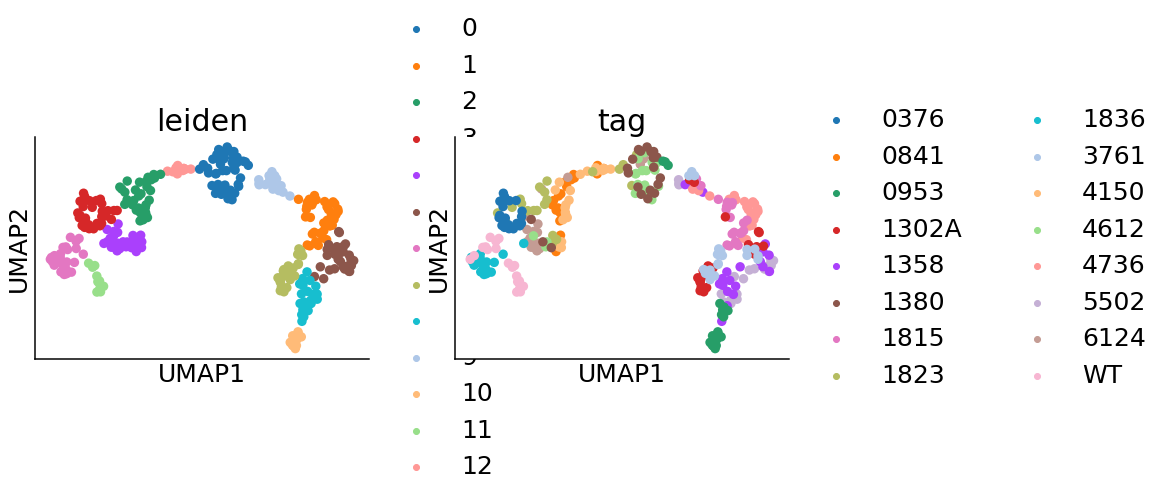

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tag' as categorical
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'compound' as categorical


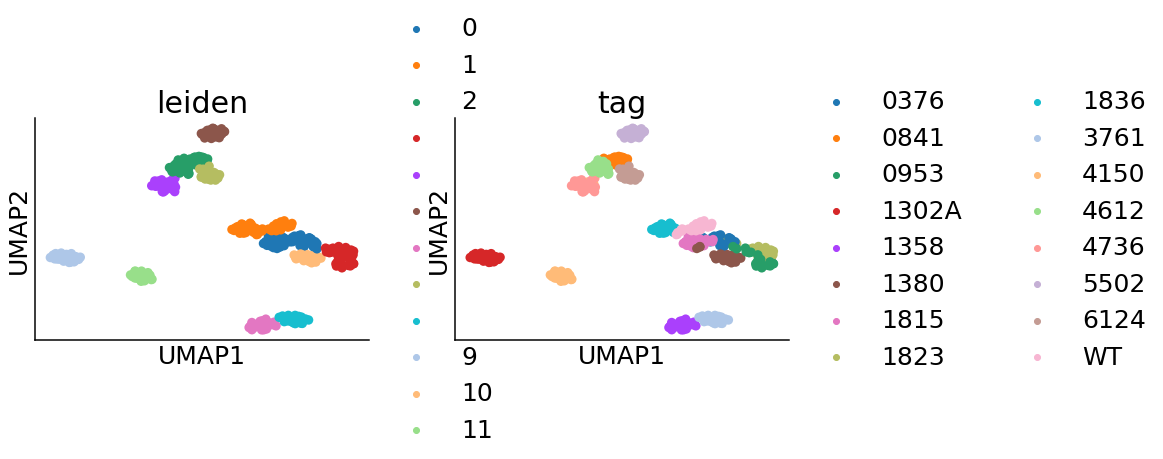

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tag' as categorical
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'compound' as categorical


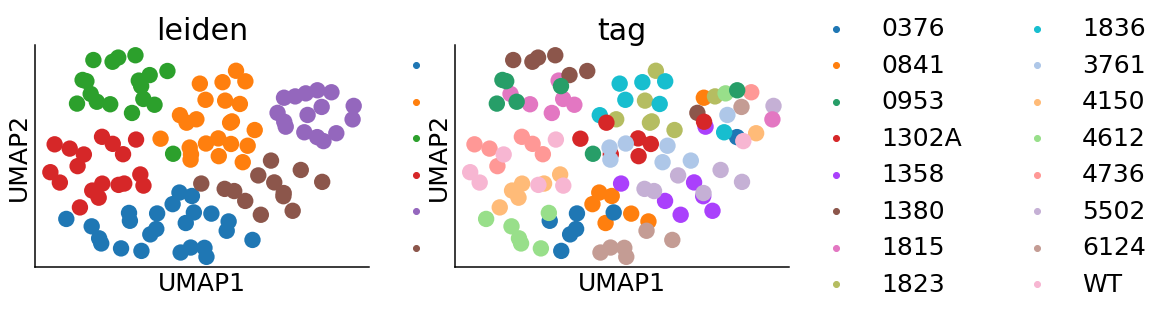

In [10]:
sc.pl.umap(oddata,color=['leiden','tag'])
sc.pl.umap(fldata,color=['leiden','tag'])
sc.pl.umap(fcdata,color=['leiden','tag'])

### Plot sfGFP/OD for all strains in subplots

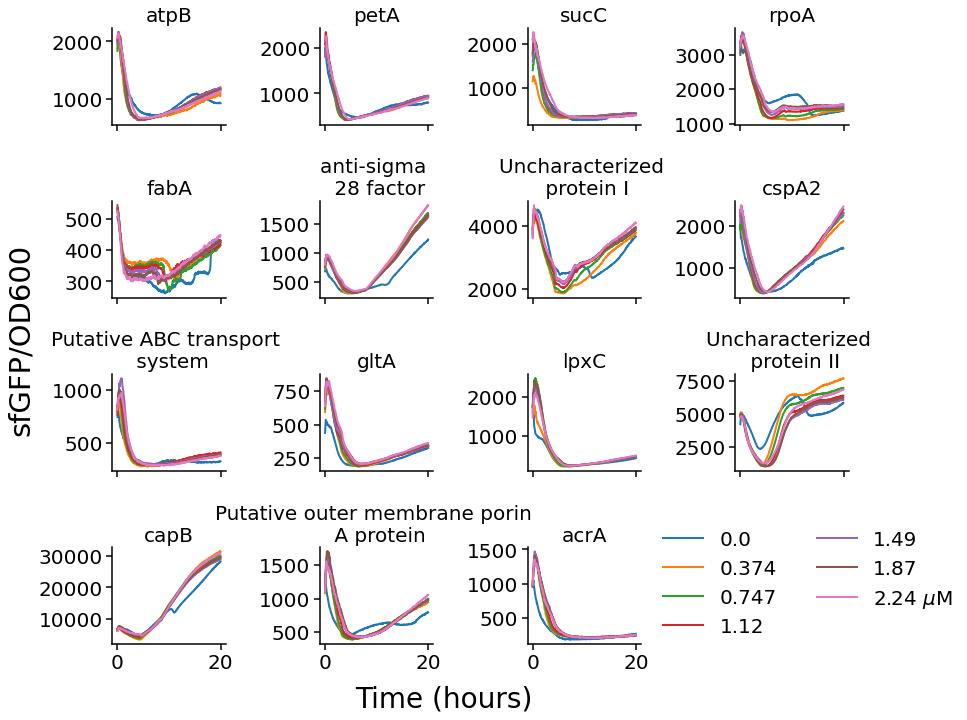

In [11]:
savefig = False

time_to_stop = 20 # in hours
nstop = int(time_to_stop*60/3)
fig, axs = plt.subplots(4,4,figsize=(12,10),sharex=True)
fig.delaxes(axs[-1,-1])
for ii, ax in enumerate(axs.reshape(-1)):
    if ii < len(all_strains):
        ax.set_title(all_genes[ii],fontsize=20)
        ax.plot(tspan[:nstop],titr_mean_dict[all_strains[ii]][:,:nstop].T)
        ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=20)
        ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=20)
fig.legend(conds_uM[:-1] + [str(conds_uM[-1])+r' $\mu$M'],frameon=False,fontsize=20,
           bbox_to_anchor=(1.11,0.26),ncol=2);
fig.text(0.5, -0.01, 'Time (hours)', ha='center',fontsize=28);
fig.text(-0.005, 0.5, 'sfGFP/OD600', va='center', rotation='vertical',fontsize=29);
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/supplementalFigs/'
                +'sfgfp_over_od.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()


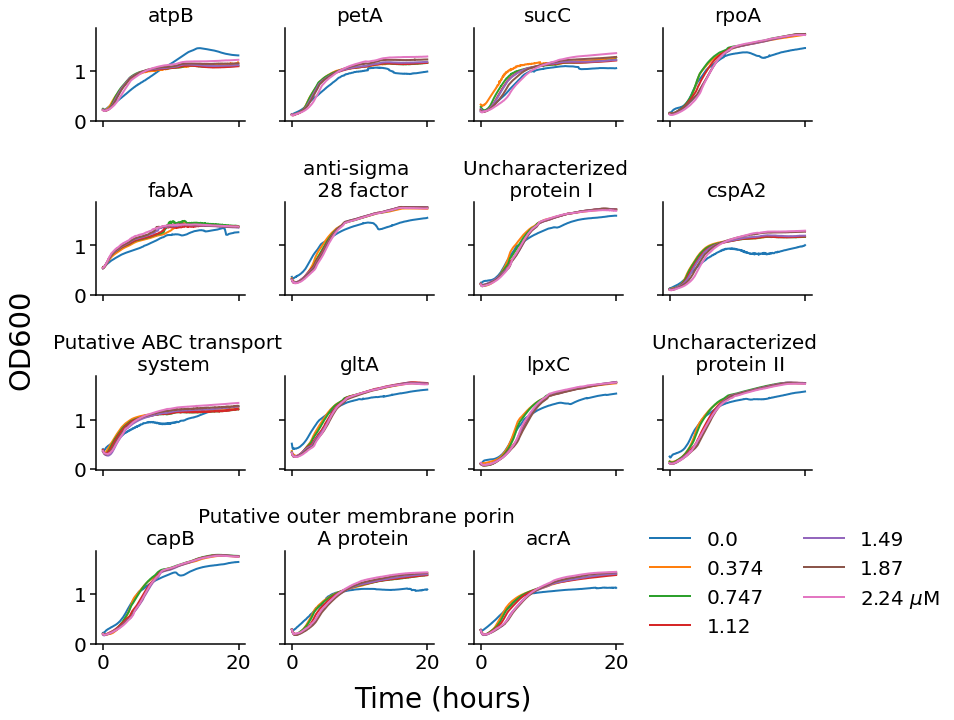

In [12]:
savefig = False

nstop = int(time_to_stop*60/3)
fig, axs = plt.subplots(4,4,figsize=(11,10),sharex=True,sharey=True)
fig.delaxes(axs[-1,-1])
for ii, ax in enumerate(axs.reshape(-1)):
    if ii < len(all_strains):
        ax.set_title(all_genes[ii],fontsize=20)
        ax.plot(tspan[:nstop],od_mean_dict[all_strains[ii]][:,:nstop].T)
        ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=20)
        ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=20)
fig.legend(conds_uM[:-1] + [str(conds_uM[-1])+r' $\mu$M'],frameon=False,fontsize=20,
           bbox_to_anchor=(1.15,0.26),ncol=2);
fig.text(0.5, -0.01, 'Time (hours)', ha='center',fontsize=28);
fig.text(-0.05, 0.5, 'OD600', va='center', rotation='vertical',fontsize=29);
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/supplementalFigs/'
                +'od.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

## Fit hill function at each timepoint

In [5]:
def f_hill_act(x,K,n): 
    y = ymin + (ymax-ymin)*(np.power(x,n)/(K**n + np.power(x,n)))
    return y

def f_hill_rep(x,K,n): 
    y = ymax - (ymax-ymin)*(np.power(x,n)/(K**n + np.power(x,n)))    
    return y

In [6]:
# fit hill function to transfer curves
doRun = False
# the flag is to prevent accidental cell execution. this cell takes quite some time to run
if doRun: 

    K_dict = {} # will contain the K values for all strains at all timepoints
    n_dict = {} # will contain the n values for all strains at all timepoints
    Y_dict = {} # hill function evaluations for all strains at all timepoints
    r2_dict = {} # r2 score for all strains at all timepoints
    perr_dict = {} # one standard deviation errors on the parameters

    for this_strain in all_strains: 

        x = [conds_uM for ii in range(3)]
        x = [this_cond for all_conds in x for this_cond in all_conds] 
        Y = np.zeros((len(conds)*3,len(tspan))) # 3 is number of replicates
        for ii in range(len(tspan)): 
            Y[:,ii] = np.concatenate(((titr_dict[this_strain+'_1'][:,ii],
                                       titr_dict[this_strain+'_2'][:,ii],
                                       titr_dict[this_strain+'_3'][:,ii])),axis=0)

        K_,n_ = [],[] # list where each element will be K, n for each timepoint 
        x_ = np.linspace(0,conds_uM[-1],100) # fine-resolution grid to evaluate the hill function on 
        Y_ = np.zeros((100,len(tspan))) # hill function 
        r2_ = []
        perr_ = []
        opt_fail_cnt = 0
        for ii in range(0,len(tspan)):

            this_y = Y[:,ii].reshape(len(conds),3,order='F')
            yargmin = np.unravel_index(this_y.argmin(),this_y.shape)    
            yargmax = np.unravel_index(this_y.argmax(),this_y.shape)

    #         # using the mean of replicates to get ymin and ymax
    #         # this calculation of ymin/ymax won't give the ymin/ymax at x=0
    #         ymin = np.mean(this_y[yargmin[0]])
    #         ymax = np.mean(this_y[yargmax[0]])

            # a calculation that will give ymin and ymax at x=0
            if yargmin < yargmax: 
                ymin = np.mean(this_y[0]) # inducer conc of 0 (x=0) is where the "min" should be
                ymax = np.mean(this_y[yargmax[0]]) 
            else: 
                ymin = np.mean(this_y[yargmin[0]])
                ymax = np.mean(this_y[0]) # inducer conc of 0 (x=0) is where the "max" should be

            # if optimal parameters are not found by curve_fit method, then it throws an error
            # using try expect block and return K,n = 0,0 if parameters not found
            try:  
                if yargmin < yargmax: 
                    (Kfit, nfit), pcov = curve_fit(f_hill_act, x, Y[:,ii],p0=[0.5,0.5],method='dogbox')
                    Y_[:,ii] = f_hill_act(x_,Kfit,nfit) 
                    r2 = r2_score(Y[:,ii],f_hill_act(x,Kfit,nfit))
                else: 
                    (Kfit, nfit), pcov = curve_fit(f_hill_rep, x, Y[:,ii],p0=[0.5,0.5],method='dogbox')
                    Y_[:,ii] = f_hill_rep(x_,Kfit,nfit)
                    r2 = r2_score(Y[:,ii],f_hill_rep(x,Kfit,nfit))
            except: 
    #             print(str(opt_fail_cnt)+') Optimal parameters could not be found at time index ' + str(ii) +
    #                  ' in strain '+ this_strain)
                Kfit, nfit = 0.0, 0.0
                opt_fail_cnt += 1
            K_.append(Kfit)
            n_.append(nfit)
            r2_.append(r2)
            perr = np.sqrt(np.diag(pcov))
            perr_.append(perr)

        K_dict[this_strain] = K_
        n_dict[this_strain] = n_
        Y_dict[this_strain] = Y_
        r2_dict[this_strain] = r2_
        perr_dict[this_strain] = perr_

In [13]:
# pickle.dump([x_,Y_dict,fcargmax_dict,fcargmax_0_dict,K_dict,n_dict],open('hill_fit_and_plot_tps.pkl','wb'))
# x_,Y_dict,fcargmax_dict,fcargmax_0_dict,K_dict,n_dict = pickle.load(open('data/hill_fit_and_plot_tps.pkl','rb'))

# pickle.dump([x_,Y_dict,fcargmax_dict,fcargmax_0_dict,K_dict,n_dict,perr_dict],open('data/hill_fit_and_plot_tps.pkl','wb'))
x_,Y_dict,fcargmax_dict,fcargmax_0_dict,K_dict,n_dict,perr_dict= pickle.load(open('data/hill_fit_and_plot_tps_.pkl','rb'))

In [8]:
# all_strains = ['6124','0841','4736','1823','3761','5502','1836','0376','1815','0953','1380','4612','4150',
#               '1358','1302A']
# all_genes = ['atpB','petA','anti-sigma 28 factor','sucC','Uncharacterized protein I','rpoA','fabA',\
#             'putative ABC transport system','gltA','lpxC','acrA','Putative outer membrane porin A',\
#             'cspA2','Uncharacterized protein II','capB']


In [60]:
def plot_tfcurves(fcargmax,offset,titr_mean,titr_std,doSave=False,saveDir='/Users/aqib/Desktop/fig.pdf'):
    # time point was chosen where max fold change occured across all timepoints

    %matplotlib inline

    plt.rcParams.update({'font.size':25});
#     plt.rc('lines',linewidth=3);
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False 
    tick_spacing = 1
    
    cmap = matplotlib.cm.get_cmap('tab20')
    
    fig,axs = plt.subplots(3,5,figsize=(24,11),sharex=True)
#     fig.delaxes(axs[-1,-1])
    for ii,ax in enumerate(axs.reshape(-1)):
        if ii < len(all_strains):
            strain = all_strains[ii]
            tplot = fcargmax[strain][1] + offset
            yplot = titr_mean[strain][:,tplot]
            errplot = titr_std[strain][:,tplot]
            Yplot = Y_dict[strain][:,tplot]

#             ax.set_title(gene_names[strain]+'\n ('+str(round(tplot*3/60,1))+' hours)',fontsize=18)
            ax.set_title(gene_names[strain],fontsize=24,x=0.5)
            ax.errorbar(conds_uM,yplot,yerr=errplot,fmt='o',mew=2,mfc=cmap(ii),ms=11,capsize=4,
                        elinewidth=3,ecolor='black',mec='black')
            ax.plot(x_,Yplot,c='k')
            for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
                ax.spines[side].set_linewidth(2)
            ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0),useMathText=True)

            ax.tick_params(axis='both',length=6,width=1.5)
            ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))

            (ax.yaxis.get_offset_text()).set_y(-10) # change x-location of y-axis multiplier
            ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
            ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
#             ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))

    fig.text(0.5, -0.02, r'[malathion] ($\mu$M)', ha='center',fontsize=28)
    fig.text(-0.02, 0.5, r'sfGFP (a.u) $\mathregular{(OD600)^{-1}}$ at time point' +'\n          of maximal fold change', va='center',
             rotation='vertical',fontsize=29)        
#     fig.legend(['model fit'],frameon=False,fontsize=22,bbox_to_anchor=(1.01,0.15));
    plt.tight_layout()
    # plt.xscale('log')
    if doSave: 
        plt.savefig(saveDir,transparent=True,bbox_inches='tight',dpi=300)
    plt.show()

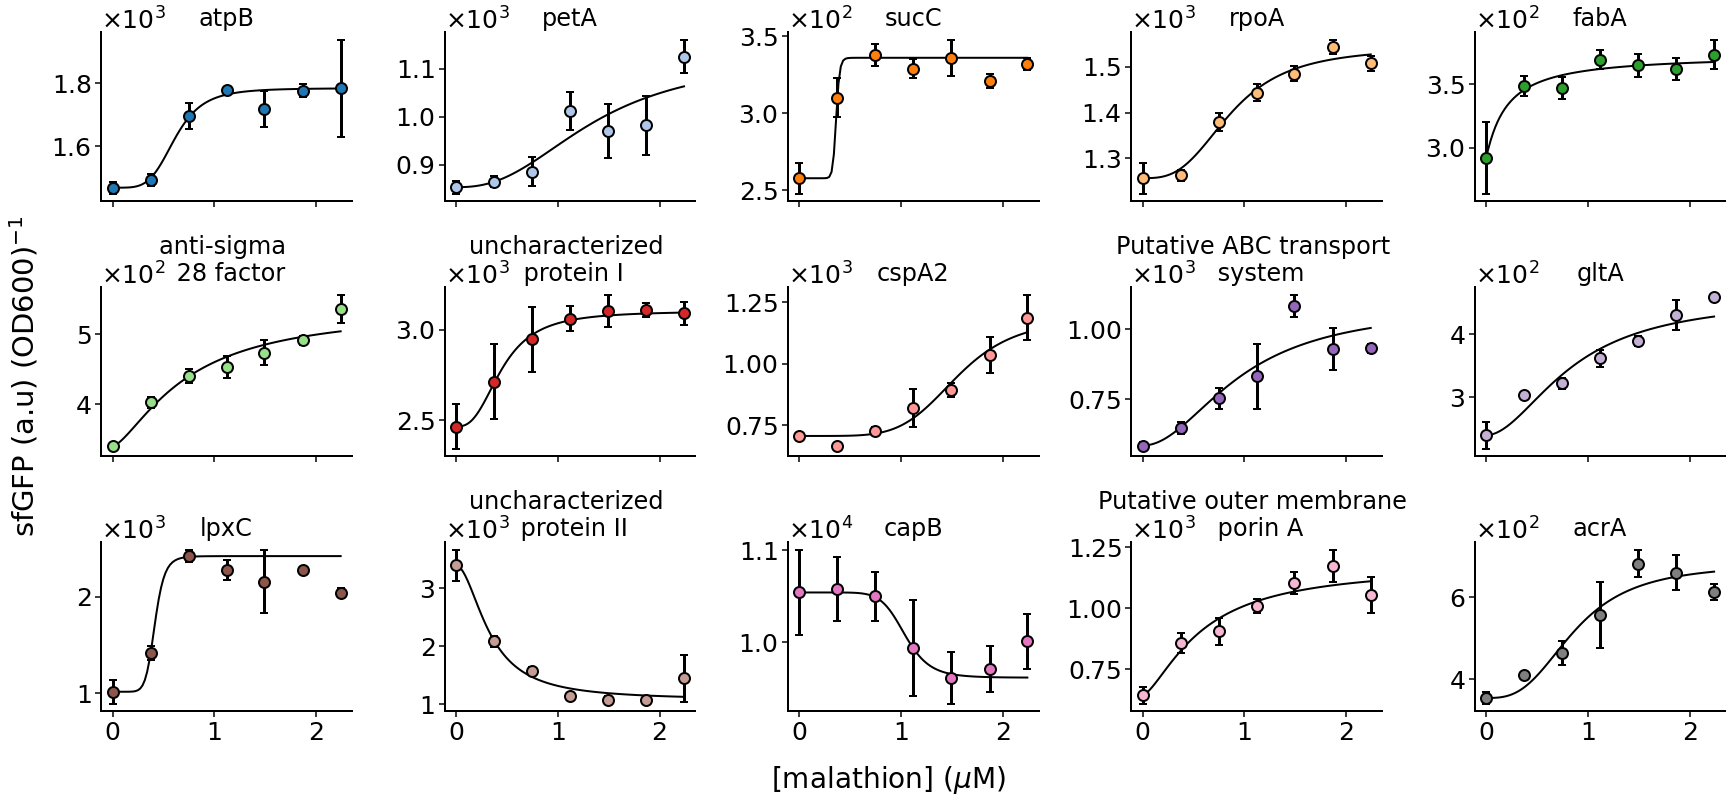

In [10]:
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig4/tf_curves.pdf'
plot_tfcurves(fcargmax_0_dict,0,titr_mean_dict,titr_std_dict,doSave=False,saveDir=figDir)

In [50]:
# timepoint update for some of the strains
fcargmax_0_dict['1823'][1] = 162
fcargmax_0_dict['1302A'][1] = 167
fcargmax_0_dict['0953'][1] = 14 # 15

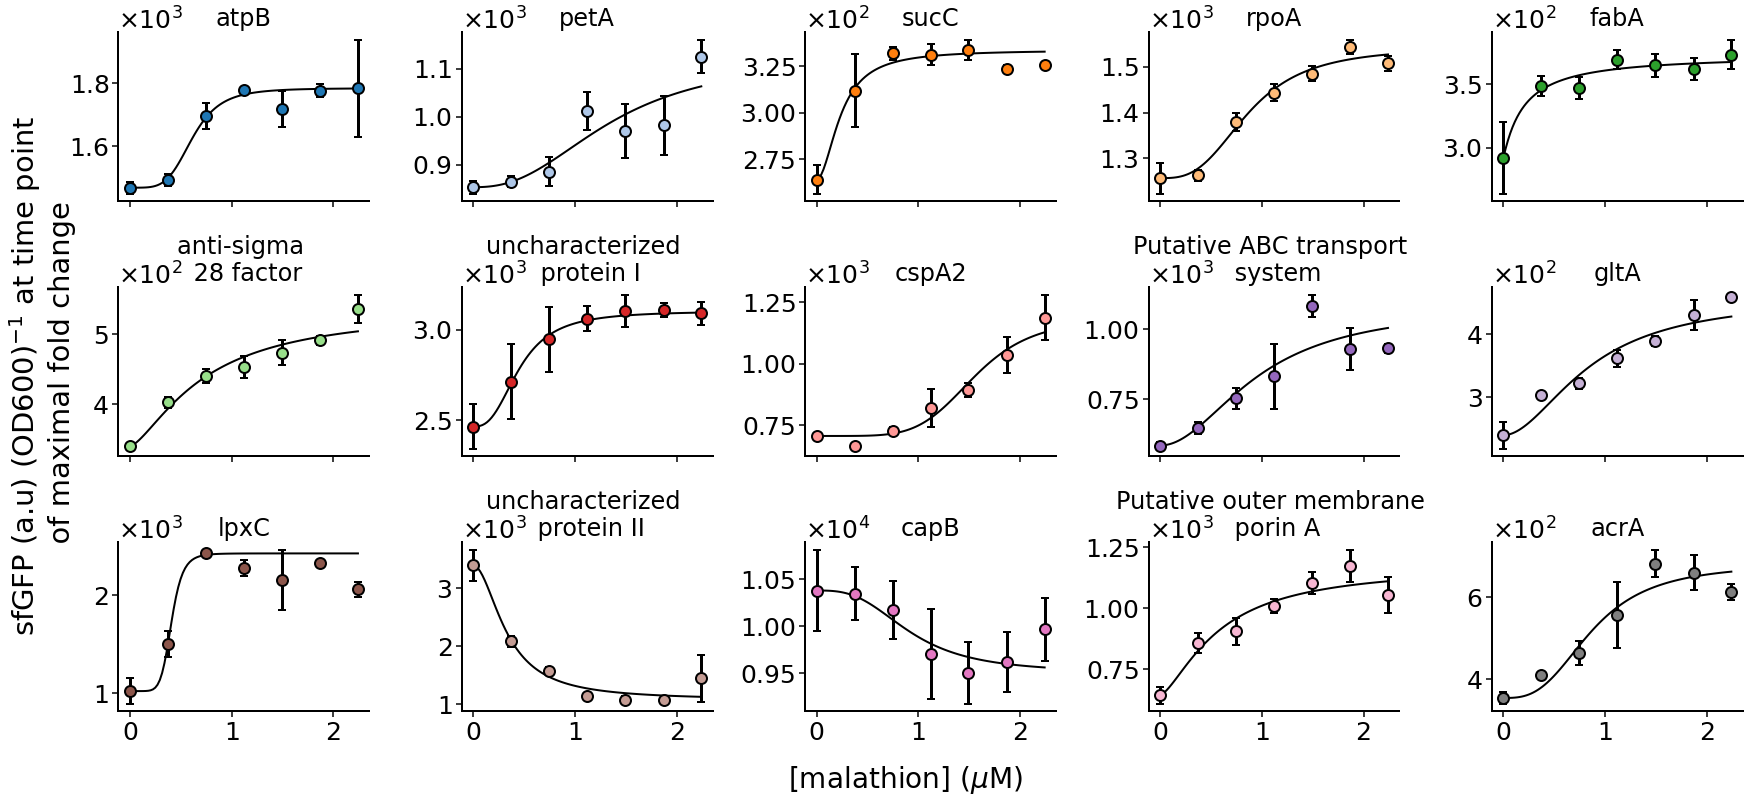

In [62]:
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig4/tf_curves.pdf'
plot_tfcurves(fcargmax_0_dict,0,titr_mean_dict,titr_std_dict,doSave=False,saveDir=figDir)

## Table 1 (partial) in manuscript

In [10]:
# create a new df (eventually latex table) with information about each strain
# what are the columns going to be: 
# strain name, locus_tag, y_max, y_min, K, n
names = ['atpB','petA','sucC','rpoA','fabA','anti-sigma 28 factor','Uncharacterized protein I',
        'cspA2','Putative ABC transport protein','gltA','lpxC','Uncharacterized protein II',
         'capB','Putative outer membrane porin A protein','acrA',]
tags = ['PFLU\_6124','PFLU\_0841','PFLU\_1823','PFLU\_5502','PFLU\_1836','PFLU\_4736','PFLU\_3761','PFLU\_4150',
        'PFLU\_0376','PFLU\_1815','PFLU\_0953','PFLU\_1358','PFLU\_1302A','PFLU\_4612','PFLU\_1380']
act_or_rep = ['Activated']*11 + ['Repressed']*2 + ['Activated']*2

ymins,ymaxs,Ks,ns = [], [], [], []
for ii, strain in enumerate(all_strains):
    if act_or_rep[ii] == 'Activated':
        ymin = (titr_mean_dict[strain])[0,fcargmax_0_dict[strain][-1]]
        ymax = np.max((titr_mean_dict[strain])[:,fcargmax_0_dict[strain][-1]])
        ymins.append(int(ymin))
        ymaxs.append(int(ymax))
    else: 
        ymin = np.min((titr_mean_dict[strain])[:,fcargmax_0_dict[strain][-1]])
        ymax = (titr_mean_dict[strain])[0,fcargmax_0_dict[strain][-1]]
        ymins.append(int(ymin))
        ymaxs.append(int(ymax))
    Ks.append(np.round((K_dict[strain])[fcargmax_0_dict[strain][-1]],1))
    ns.append(np.round((n_dict[strain])[fcargmax_0_dict[strain][-1]],1))
    
d={'Malathion reporter':names,'Locus tag':tags,'Act./Rep.':act_or_rep,
   r'$y_{min}$':ymins,r'$y_{max}$':ymaxs,r'$K_M$':Ks,r'$n$':ns}
reporter_table = pd.DataFrame(d)

In [11]:
print(reporter_table.to_latex(index=False, escape=False))

\begin{tabular}{lllrrrr}
\toprule
                     Malathion reporter &   Locus tag & Act./Rep. &  $y_{min}$ &  $y_{max}$ &  $K_M$ &  $n$ \\
\midrule
                                   atpB &  PFLU\_6124 & Activated &       1467 &       1783 &    0.6 &  4.5 \\
                                   petA &  PFLU\_0841 & Activated &        853 &       1125 &    1.4 &  2.4 \\
                                   sucC &  PFLU\_1823 & Activated &        263 &        333 &    0.2 &  1.9 \\
                                   rpoA &  PFLU\_5502 & Activated &       1256 &       1542 &    0.9 &  3.0 \\
                                   fabA &  PFLU\_1836 & Activated &        292 &        373 &    0.2 &  1.1 \\
                   anti-sigma 28 factor &  PFLU\_4736 & Activated &        339 &        535 &    0.7 &  1.5 \\
              Uncharacterized protein I &  PFLU\_3761 & Activated &       2465 &       3110 &    0.5 &  2.7 \\
                                  cspA2 &  PFLU\_4150 & Activated &  

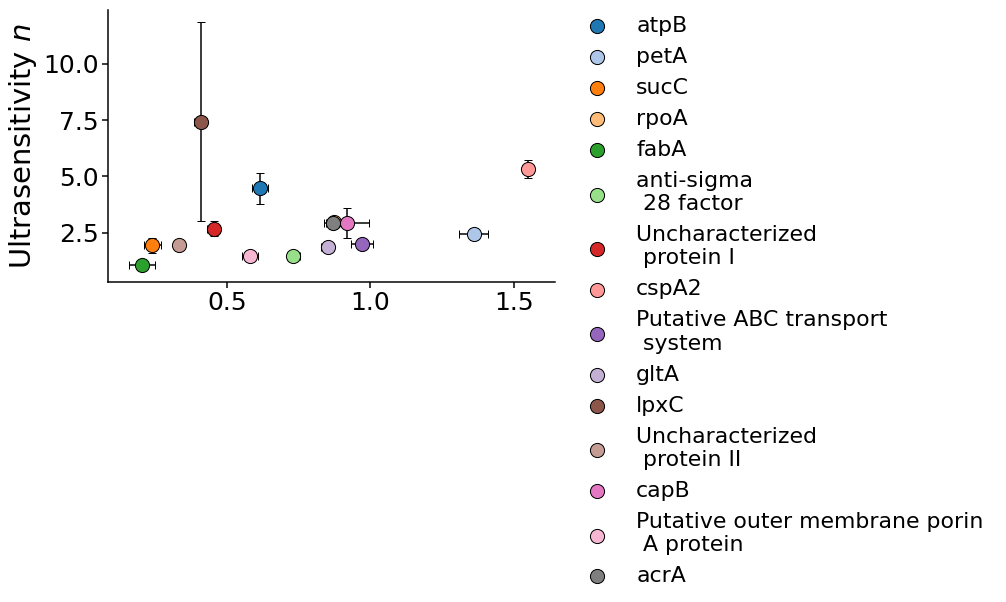

In [10]:
### scatterplot of n vs Km

savefig = False

cmap = matplotlib.cm.get_cmap('tab20')
fig,ax = plt.subplots(figsize=(8,5))
for ii, strain in enumerate(all_strains):
    xerr = perr_dict[strain][fcargmax_0_dict[strain][1]][0]/(3) # SE
    yerr = perr_dict[strain][fcargmax_0_dict[strain][1]][1]/(3)
    ax.errorbar(K_dict[strain][fcargmax_0_dict[strain][1]],n_dict[strain][fcargmax_0_dict[strain][1]],
                 xerr=xerr,yerr=yerr,fmt='.',capsize=4,linewidth=1.5,color='k',zorder=0)
    ax.scatter(K_dict[strain][fcargmax_0_dict[strain][1]],n_dict[strain][fcargmax_0_dict[strain][1]],s=200,
                linewidth=1,edgecolor='k',color=cmap(ii),label=all_genes[ii],zorder=1)
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')

ax.legend(frameon=False,fontsize=22,ncol=1,bbox_to_anchor=(1.0,1.05))
plt.ylabel(r'Ultrasensitivity $n$',fontsize=29); 
if savefig: 
    plt.savefig('/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig4/'
                +'hill_fit_scatter.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

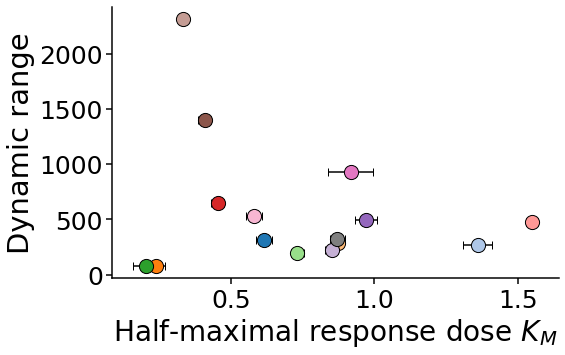

In [11]:
dr = np.array(ymaxs) - np.array(ymins)

### scatterplot of n vs Km

savefig = False

cmap = matplotlib.cm.get_cmap('tab20')
fig,ax = plt.subplots(figsize=(8,5))
for ii, strain in enumerate(all_strains):
    xerr = perr_dict[strain][fcargmax_0_dict[strain][1]][0]/(3) # SE
    ax.errorbar(K_dict[strain][fcargmax_0_dict[strain][1]],dr[ii],
                 xerr=xerr,fmt='.',capsize=4,linewidth=1.5,color='k',zorder=0)
    ax.scatter(K_dict[strain][fcargmax_0_dict[strain][1]],dr[ii],s=200,
                linewidth=1,edgecolor='k',color=cmap(ii),label=all_genes[ii],zorder=1)
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')

# ax.legend(frameon=False,fontsize=22,ncol=1,bbox_to_anchor=(1.0,1.05))
plt.xlabel(r'Half-maximal response dose $K_M$',fontsize=28); plt.ylabel(r'Dynamic range',fontsize=29); 
if savefig: 
    plt.savefig('/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig4/'
                +'dr_Km_scatter.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

### Visualize fold change over time as heatmap

In [13]:
# need to remove the '\n' from each gene name
hm_gene_names =[x.replace('\n ','') for x in all_genes]
hm_gene_names[-2] = hm_gene_names[-2].replace(' protein','')

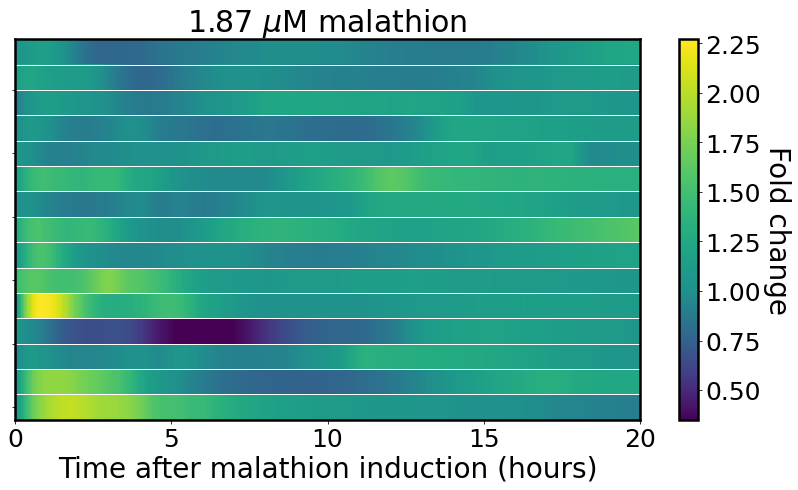

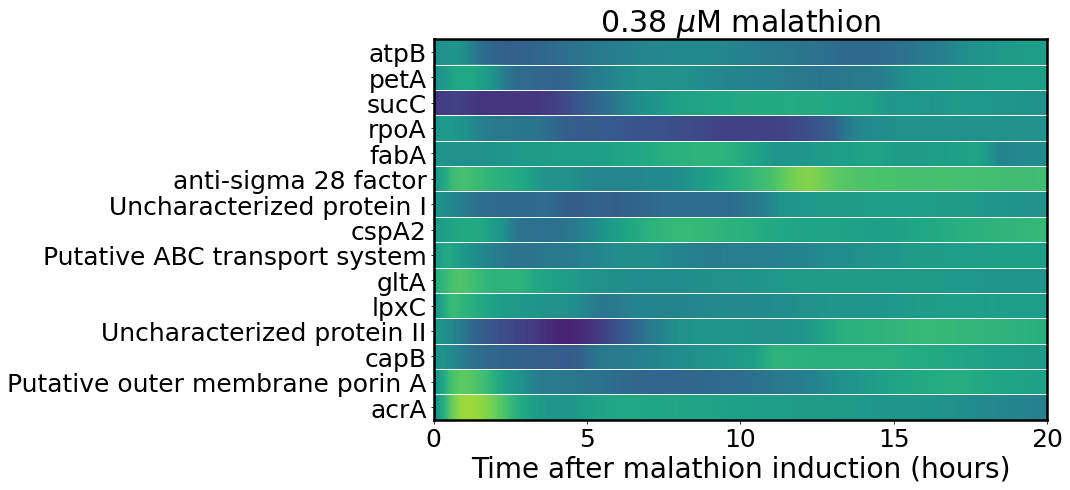

In [194]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig4/'
# plt.rcParams.update({'font.size':22});
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0.35, vcenter=1.0, vmax=2.27)

this_cond = 5
fc_list = []
for strain in all_strains:
    fc_list.append(titr_fc_dict[strain][this_cond])    
fig1,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_title(r'1.87 $\mu$M malathion')
f = ax.imshow(savgol(np.array(fc_list)[:,0:400],11,1,axis=1),aspect='auto',interpolation='nearest',\
              extent=[0,20,-0.5,14.5],cmap='viridis',norm=divnorm)
# ax.set_yticks(list(range(15)))
ax.set_xticks(list(range(0,25,5)))
cb = plt.colorbar(f)
cb.outline.set_linewidth(2.5)
cbylab = cb.ax.set_ylabel('Fold change',fontsize=28,rotation=270,labelpad=30)
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
ax.set_xlabel('Time after malathion induction (hours)',fontsize=28)
ax.set_yticklabels([],fontsize=25)
ax.hlines([ii + 0.5 for ii in list(range(15)) ],0,20,color='white',lw=1)

this_cond = 1
fc_list = []
for strain in all_strains:
    fc_list.append(titr_fc_dict[strain][this_cond])    
fig2,ax = plt.subplots(1,1,figsize=(11,7))
ax.set_title(r'0.38 $\mu$M malathion')
f = ax.imshow(savgol(np.array(fc_list)[:,0:400],11,1,axis=1),aspect='auto',interpolation='nearest',\
              extent=[0,20,-0.5,14.5],cmap='viridis',norm=divnorm)
ax.set_yticks(list(range(15)))
ax.set_xticks(list(range(0,25,5)))
# cb = plt.colorbar(f)
# cb.outline.set_linewidth(2.5)
# cbylab = cb.ax.set_ylabel('Fold change for 0.38 mM malathion',fontsize=24,rotation=270,labelpad=30)
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
ax.set_xlabel('Time after malathion induction (hours)',fontsize=28)
ax.set_yticklabels(hm_gene_names[::-1],fontsize=25)
ax.hlines([ii + 0.5 for ii in list(range(15)) ],0,20,color='white',lw=1)

if savefig: 
    fig1.savefig(figDir+'time_series_hmap_high.pdf',dpi=300,bbox_inches='tight',transparent=True)
    fig2.savefig(figDir+'time_series_hmap_low.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()



## Environmental screens 

The experiment was structured as follows: 
- Soil (harvest supreme) was placed in 5 gallon plant pots and cabbage plants (Copenhagen cabbage) were transplanted into the soil. There were total 3 plants.
- Three mixtures were used for the three experimental conditions: 
    1. No spectracide -- plant was sprayed with an outdoor garden hose for 1 minute
    2. 1x spectracide (working concentration recommended by the manufacturer) -- 1oz per gallon of water sprayed for 1 minute
    3. 8x spectracide -- 8oz per gallon of water sprayed for 1 minute
- The runoff was caught in a tray and collected into 1L pyrex, autoclaved bottles. 
- The samples were brought back to the lab and processed: 
    - First, the samples were strained using a 40 µm cell strainer to remove large particles and insects
    - Second, the samples were centrifuged to separate the remaining soil particles from the runoff solution
    - Lastly, the supernatant from above was vacuum sterile filtered using a 0.22 µm membrane
- To be consistent with the first set of reporter screens, we added 6 µL of the solution to 244 µL of cells (grown in the same way as before) and same plate reader protocol was run

In [12]:
strains = ['6124','0841','1823','5502','1836','1815','4736','4150','3761','0376','0953','4612',
          '1358','1302A','1380']
# tp_dict = {'6124':19,'0841':40,'1823':161,'5502':300,'1836':280,'1815':63,'4736':63,'4150':48,
#            '3761':257,'0376':18,'0953':15,'4612':39,'1358':111,'1302A':169,'1380':62}
last_tp = 600
tp_dict = {}
for strain in strains:
    tp_dict[strain] = last_tp 

In [13]:
# Plate 1
all_wells = gen_well_keys(8,12) # enumerates all the well keys on a 96 well plate
conds = [8, 1, 0] # oz spectracide per gallon of water

ddir = 'data/malathion-reporter-plate-reader/' # data directory with plate reader curves

# generate dictionary with list of well locations and strain id as key 
labels = {'6124_8x':all_wells[13:16],'6124_1x':all_wells[16:19],'6124_0x':all_wells[19:22],
          '0841_8x':all_wells[13+12:16+12],'0841_1x':all_wells[16+12:19+12],'0841_0x':all_wells[19+12:22+12],
          '1823_8x':all_wells[13+24:16+24],'1823_1x':all_wells[16+24:19+24],'1823_0x':all_wells[19+24:22+24],
          '5502_8x':all_wells[13+36:16+36],'5502_1x':all_wells[16+36:19+36],'5502_0x':all_wells[19+36:22+36],
          '1836_8x':all_wells[13+48:16+48],'1836_1x':all_wells[16+48:19+48],'1836_0x':all_wells[19+48:22+48],
          '1815_8x':all_wells[13+60:16+60],'1815_1x':all_wells[16+60:19+60],'1815_0x':all_wells[19+60:22+60]}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'env_mal_reporter_screen_plate1_5.10.22.txt',8,12,3)

In [14]:
LBblank = gfpn['B11'][0:last_tp].mean()
LBmal0 = gfpn['C11'][0:last_tp].mean()
LBmal1 = gfpn['D11'][0:last_tp].mean()
LBmal8 = gfpn['E11'][0:last_tp].mean()
blanks = [LBblank,LBmal0,LBmal1,LBmal8]
np.min(blanks[1:])
blanks = [blank - np.min(blanks) for blank in blanks]

In [15]:
# write the relevant reporter data to a separate dictionary 
keep_strains_1 =  ['6124', '0841', '1823', '5502', '1836', '1815'] # ['4736', '4612', '3761'] for plate 2, none for plate 3
env_gfpn_dict = {}
for strain in keep_strains_1:
    env_gfpn_dict[strain] = np.array(
                    [(np.concatenate([gfpn[key][tp_dict[strain]]-blanks[1] for key in labels[strain+'_0x']])),
                     (np.concatenate([gfpn[key][tp_dict[strain]]-blanks[2] for key in labels[strain+'_1x']])),
                     (np.concatenate([gfpn[key][tp_dict[strain]]-blanks[3] for key in labels[strain+'_8x']]))])


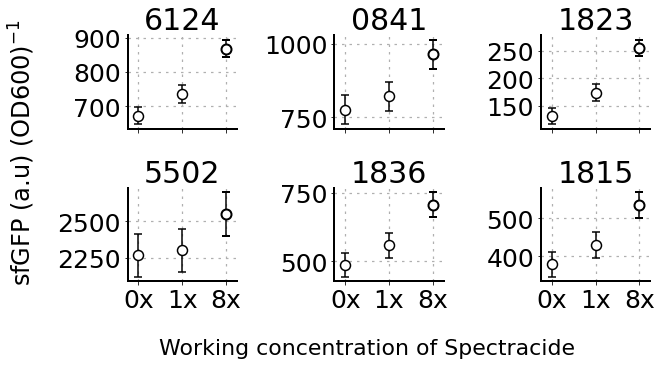

In [16]:
fig,axs = plt.subplots(2,3,figsize=(9,5),sharex=True)
for ii,ax in enumerate(axs.reshape(-1)):
    strain = strains[ii]
    ax.set_title(strain)
    gfpn8 = np.concatenate([gfpn[key][tp_dict[strain]] - blanks[3] for key in labels[strain + '_8x']])
    ax.errorbar(2,np.mean(gfpn8),yerr=np.std(gfpn8),fmt='o',mew=2,mfc='white',ms=10,capsize=4,
                        elinewidth=1.5,ecolor='black',mec='black')
    gfpn1 = np.concatenate([gfpn[key][tp_dict[strain]] - blanks[2] for key in labels[strain + '_1x']])
    ax.errorbar(1,np.mean(gfpn1),yerr=np.std(gfpn8),fmt='o',mew=1.5,mfc='white',ms=10,capsize=4,
                        elinewidth=1.5,ecolor='black',mec='black')
    gfpn0 = np.concatenate([gfpn[key][tp_dict[strain]] - blanks[1] for key in labels[strain + '_0x']])
    ax.errorbar(0,np.mean(gfpn0),yerr=np.std(gfpn8),fmt='o',mew=1.5,mfc='white',ms=10,capsize=4,
                        elinewidth=1.5,ecolor='black',mec='black')
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(2)
    ax.grid(linestyle=':',linewidth=1.25,dashes=(2,4))

ax.set_xticks([0,1,2])
ax.set_xticklabels(['0x','1x','8x'])
ax.set_xlim(-0.25,2.25)
fig.text(0.52, -0.04, 'Working concentration of Spectracide', ha='center',fontsize=22)
fig.text(-0.035, 0.52, r'sfGFP (a.u) $\mathregular{(OD600)^{-1}}$', va='center', rotation='vertical',fontsize=24)        
plt.tight_layout()
plt.show()

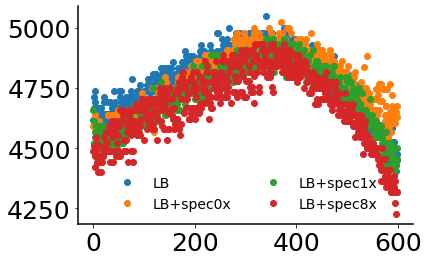

In [17]:
plt.plot(gfpn['B11'][0:tp_dict['6124']],'o',label='LB')
plt.plot(gfpn['C11'][0:tp_dict['6124']],'o',label='LB+spec0x')
plt.plot(gfpn['D11'][0:tp_dict['6124']],'o',label='LB+spec1x')
plt.plot(gfpn['E11'][0:tp_dict['6124']],'o',label='LB+spec8x')
plt.legend(frameon=False,ncol=2,fontsize=14)
plt.show()

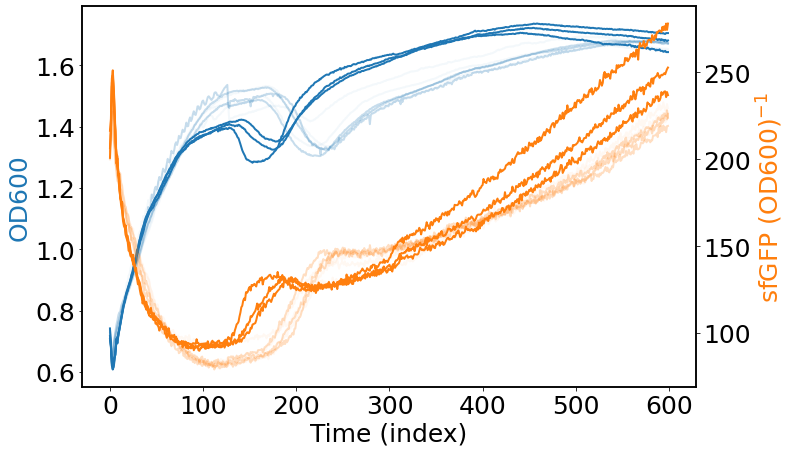

In [201]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
fig, ax1 = plt.subplots(figsize=(11,7))
strain = '1823'
last_tp = 600
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for key in labels[strain + '_8x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10)
for key in labels[strain + '_1x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10,alpha=0.25)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10,alpha=0.25)
for key in labels[strain + '_0x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10,alpha=0.05)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10,alpha=0.05)    
ax1.set_ylabel('OD600',color='tab:blue')
ax2.set_ylabel(r'sfGFP (OD600)$^{-1}$',color='tab:orange')
ax1.set_xlabel('Time (index)')
# ax1.set_xlim(-50,600)
plt.show()

In [18]:
# Plate 2
all_wells = gen_well_keys(8,12) # enumerates all the well keys on a 96 well plate
conds = [8, 1, 0] # oz spectracide per gallon of water

ddir = 'data/malathion-reporter-plate-reader/' # data directory with plate reader curves

# generate dictionary with list of well locations and strain id as key 
labels = {'4736_8x':all_wells[13:16],'4736_1x':all_wells[16:19],'4736_0x':all_wells[19:22],
          '4150_8x':all_wells[13+12:16+12],'4150_1x':all_wells[16+12:19+12],'4150_0x':all_wells[19+12:22+12],
          '3761_8x':all_wells[13+24:16+24],'3761_1x':all_wells[16+24:19+24],'3761_0x':all_wells[19+24:22+24],
          '0376_8x':all_wells[13+36:16+36],'0376_1x':all_wells[16+36:19+36],'0376_0x':all_wells[19+36:22+36],
          '0953_8x':all_wells[13+48:16+48],'0953_1x':all_wells[16+48:19+48],'0953_0x':all_wells[19+48:22+48],
          '4612_8x':all_wells[13+60:16+60],'4612_1x':all_wells[16+60:19+60],'4612_0x':all_wells[19+60:22+60]}
# 4150, 0x, bad replicate 3, didn't add the correct strain
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'env_mal_reporter_screen_plate2_5.10.22.txt',8,12,3)

In [203]:
LBblank = gfpn['B11'][0:last_tp].mean()
LBmal0 = gfpn['C11'][0:last_tp].mean()
LBmal1 = gfpn['D11'][0:last_tp].mean()
LBmal8 = gfpn['E11'][0:last_tp].mean()
blanks = [LBblank,LBmal0,LBmal1,LBmal8]
np.min(blanks[1:])
blanks = [blank - np.min(blanks) for blank in blanks]

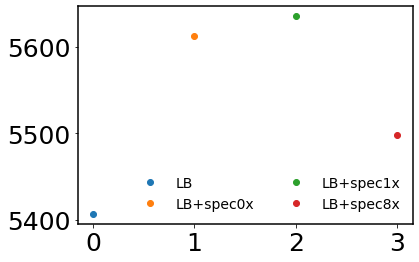

In [204]:
plt.plot(0,gfpn['B11'][0:tp_dict['6124']].mean(),'o',label='LB')
plt.plot(1,gfpn['C11'][0:tp_dict['6124']].mean(),'o',label='LB+spec0x')
plt.plot(2,gfpn['D11'][0:tp_dict['6124']].mean(),'o',label='LB+spec1x')
plt.plot(3,gfpn['E11'][0:tp_dict['6124']].mean(),'o',label='LB+spec8x')
plt.legend(frameon=False,ncol=2,fontsize=14)
plt.show()

In [19]:
# write the relevant reporter data to a separate dictionary 
keep_strains_2 = ['4736', '4612', '3761'] # for plate 2, none for plate 3
for strain in keep_strains_2:
    env_gfpn_dict[strain] = np.array(
                    [(np.concatenate([gfpn[key][tp_dict[strain]]-blanks[1] for key in labels[strain+'_0x']])),
                     (np.concatenate([gfpn[key][tp_dict[strain]]-blanks[2] for key in labels[strain+'_1x']])),
                     (np.concatenate([gfpn[key][tp_dict[strain]]-blanks[3] for key in labels[strain+'_8x']]))])

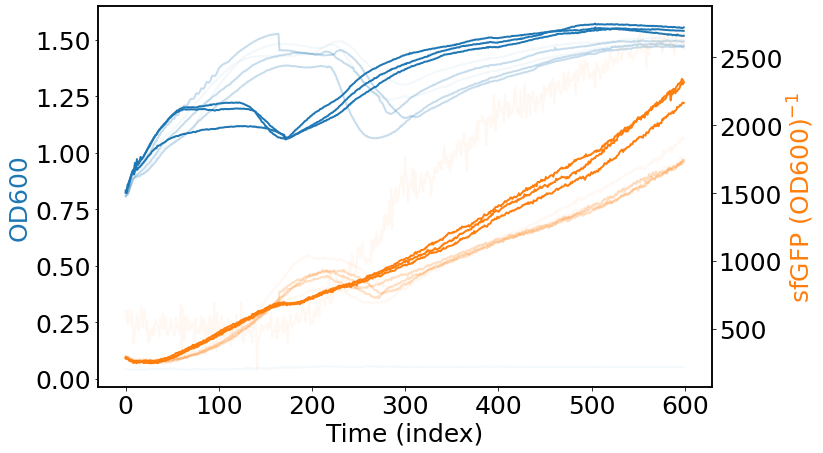

In [206]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
fig, ax1 = plt.subplots(figsize=(11,7))
strain = '4150'
last_tp = 600
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for key in labels[strain + '_8x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10)
for key in labels[strain + '_1x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10,alpha=0.25)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10,alpha=0.25)
for key in labels[strain + '_0x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10,alpha=0.05)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10,alpha=0.05)    
ax1.set_ylabel('OD600',color='tab:blue')
ax2.set_ylabel(r'sfGFP (OD600)$^{-1}$',color='tab:orange')
ax1.set_xlabel('Time (index)')
# ax1.set_xlim(-50,600)
plt.show()

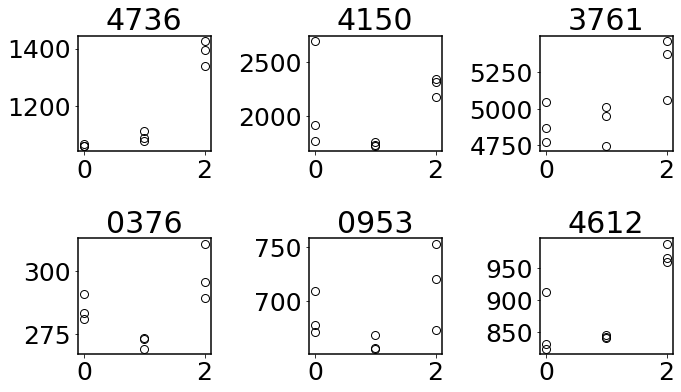

In [207]:
fig,axs = plt.subplots(2,3,figsize=(10,6))
for ii,ax in enumerate(axs.reshape(-1)):
    strain = strains[ii+6]
    ax.set_title(strain)
    for key in labels[strain + '_8x']:
        ax.plot(2,gfpn[key][tp_dict[strain]],'o',ms=8,color='k',mfc='None')
    for key in labels[strain + '_1x']:    
        ax.plot(1,gfpn[key][tp_dict[strain]],'o',ms=8,color='k',mfc='None')
    for key in labels[strain + '_0x']:    
        ax.plot(0,gfpn[key][tp_dict[strain]],'o',ms=8,color='k',mfc='None')
plt.tight_layout()
plt.show()

In [20]:
# Plate 3
all_wells = gen_well_keys(8,12) # enumerates all the well keys on a 96 well plate
conds = [8, 1, 0] # oz spectracide per gallon of water

ddir = 'data/malathion-reporter-plate-reader/' # data directory with plate reader curves

# generate dictionary with list of well locations and strain id as key 
labels = {'1358_8x':all_wells[13:16],'1358_1x':all_wells[16:19],'1358_0x':all_wells[19:22],
          '1302A_8x':all_wells[13+12:16+12],'1302A_1x':all_wells[16+12:19+12],'1302A_0x':all_wells[19+12:22+12],
          '1380_8x':all_wells[13+24:16+24],'1380_1x':all_wells[16+24:19+24],'1380_0x':all_wells[19+24:22+24],}
# parse data file
od,gfp,gfpn,tspan = get_data(ddir+'env_mal_reporter_screen_plate3_5.10.22.txt',8,12,3)

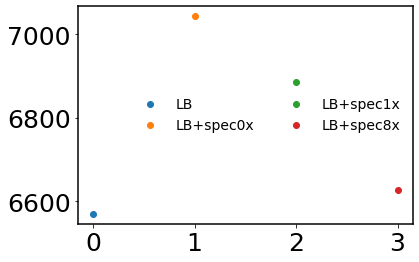

In [209]:
plt.plot(0,gfpn['B11'][0:tp_dict['6124']].mean(),'o',label='LB')
plt.plot(1,gfpn['C11'][0:tp_dict['6124']].mean(),'o',label='LB+spec0x')
plt.plot(2,gfpn['D11'][0:tp_dict['6124']].mean(),'o',label='LB+spec1x')
plt.plot(3,gfpn['E11'][0:tp_dict['6124']].mean(),'o',label='LB+spec8x')
plt.legend(frameon=False,ncol=2,fontsize=14)
plt.show()

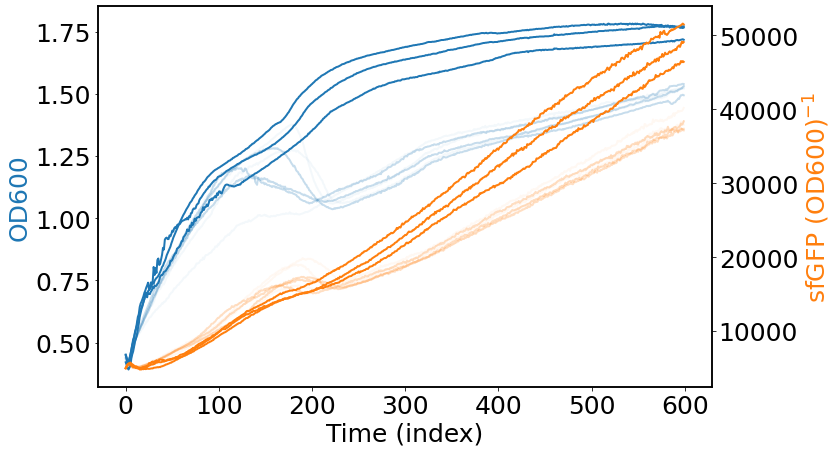

In [210]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
fig, ax1 = plt.subplots(figsize=(11,7))
strain = '1302A'
last_tp = 600
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for key in labels[strain + '_8x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10)
for key in labels[strain + '_1x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10,alpha=0.25)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10,alpha=0.25)
for key in labels[strain + '_0x']:
    ax1.plot(od[key][:last_tp],'-',c='tab:blue',markevery=10,alpha=0.05)
    ax2.plot(gfpn[key][:last_tp],'-',c='tab:orange',markevery=10,alpha=0.05)    
ax1.set_ylabel('OD600',color='tab:blue')
ax2.set_ylabel(r'sfGFP (OD600)$^{-1}$',color='tab:orange')
ax1.set_xlabel('Time (index)')
# ax1.set_xlim(-50,600)
plt.show()

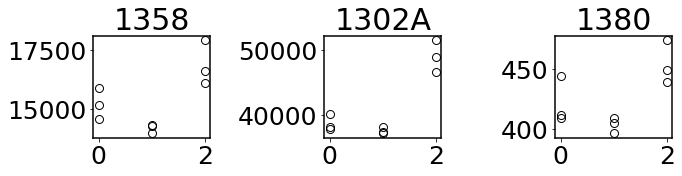

In [211]:
fig,axs = plt.subplots(1,3,figsize=(10,3))
for ii,ax in enumerate(axs.reshape(-1)):
    strain = strains[ii+12]
    ax.set_title(strain)
    for key in labels[strain + '_8x']:
        ax.plot(2,gfpn[key][tp_dict[strain]],'o',ms=8,color='k',mfc='None')
    for key in labels[strain + '_1x']:    
        ax.plot(1,gfpn[key][tp_dict[strain]],'o',ms=8,color='k',mfc='None')
    for key in labels[strain + '_0x']:    
        ax.plot(0,gfpn[key][tp_dict[strain]],'o',ms=8,color='k',mfc='None')
plt.tight_layout()
plt.show()

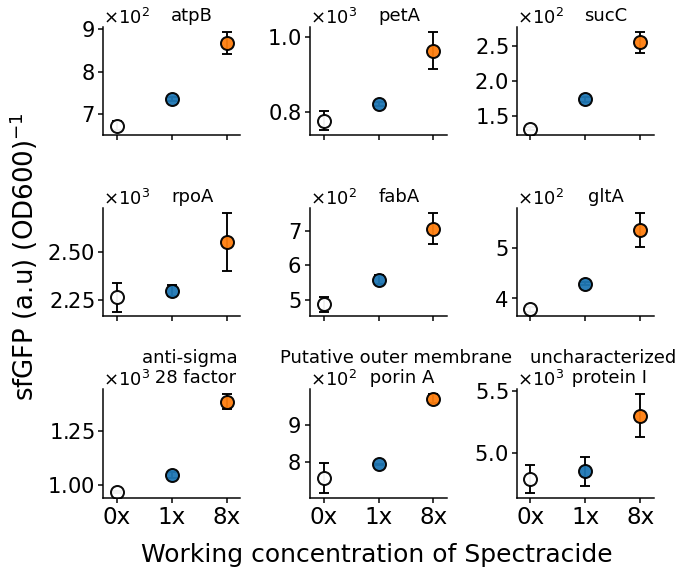

In [21]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig7/reporters_signal_env.pdf'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
fig,axs = plt.subplots(3,3,figsize=(9,8),sharex=True)
colors = ['white','tab:blue','tab:orange']
for ii,ax in enumerate(axs.reshape(-1)):
    strain = list(env_gfpn_dict.keys())[ii]
    ax.set_title(gene_names[strain],fontsize=18,x=0.65)
    for jj in range(len(env_gfpn_dict[strain])):
        ax.errorbar(jj,np.mean(env_gfpn_dict[strain][jj]),yerr=np.std(env_gfpn_dict[strain][jj]),fmt='o',mew=2,
                    mfc=colors[jj],ms=13,capsize=5,elinewidth=2,ecolor='black',mec='black',alpha=0.95)
#     for side in ax.spines.keys():
#         ax.spines[side].set_linewidth(2)
#     ax.grid(linestyle=':',linewidth=1.25,dashes=(2,4))
    ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0),useMathText=True)

#     ax.tick_params(axis='both',length=6,width=3,)
#     ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))

    (ax.yaxis.get_offset_text()).set_y(-10) # change x-location of y-axis multiplier
    (ax.yaxis.get_offset_text()).set_fontsize(18)
    ax.xaxis.set_tick_params(which='both', size=5, width=1.5, direction='out', labelsize=23)
    ax.yaxis.set_tick_params(which='both', size=5, width=1.5, direction='out',labelsize=21)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['0x','1x','8x'])
ax.set_xlim(-0.25,2.25)
fig.text(0.53, -0.01, 'Working concentration of Spectracide', ha='center',fontsize=25)
fig.text(-0.04, 0.52, r'sfGFP (a.u) $\mathregular{(OD600)^{-1}}$', va='center', rotation='vertical',fontsize=26)        
plt.tight_layout()
if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()

In [22]:
from scipy.optimize import fsolve
def func(u):
    ret = y  - (ymin + (ymax - ymin) * u**thisn / (thisK + u**thisn))
    return ret

roots = [[] for ii in range(9)]
ics = [1,1,1,1,1,1,0.4,1,1]
for ii,strain in enumerate(['6124','0841','1823','5502','1836','1815','4736','4612','3761']):
    thisK = K_dict[strain][fcargmax_0_dict[strain][1]]
    thisn = n_dict[strain][fcargmax_0_dict[strain][1]]
    ymin = titr_mean_dict[strain][0,fcargmax_0_dict[strain][1]]
    ymax = titr_mean_dict[strain][-1,fcargmax_0_dict[strain][1]]
    if (ymin - np.mean(env_gfpn_dict[strain][0])) > 0:
        Y = np.mean(env_gfpn_dict[strain],axis=1) + (ymin - np.mean(env_gfpn_dict[strain][0]) )
    else: 
        Y = np.mean(env_gfpn_dict[strain],axis=1) - (np.mean(env_gfpn_dict[strain][0]) - ymin )
    for jj,y in enumerate([Y[1],Y[2]]):
        if y < ymin:
            roots[ii].append(0.0)
        elif y > ymax: 
            roots[ii].append(2.0)
        else:
            root = fsolve(func,ics[ii])
            root, pcov = curve_fit(func, )
            roots[ii].append(root[0])
            
roots

<ipython-input-22-f30b1f8e857c>:3: RuntimeWarning: invalid value encountered in power
  ret = y  - (ymin + (ymax - ymin) * u**thisn / (thisK + u**thisn))
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[[0.6540483035441672, 0.9985895532210027],
 [0.5850104445883542, 1.580504386077191],
 [0.7187027292174284, 2.0],
 [0.515538695255611, 2.0],
 [1.5000077954510802, 2.0],
 [0.4848433225829763, 1.4733505963470852],
 [0.6107179658680206, 2.0],
 [1.0, 0.7358720610540816],
 [1.0, 1.2590079297957533]]

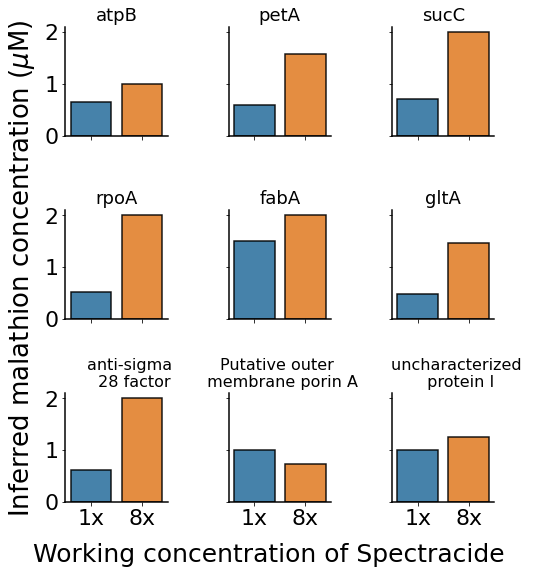

In [23]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig7/inferred_mal_env.pdf'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
fig,axs = plt.subplots(3,3,figsize=(7,8),sharex=True,sharey=True)
for ii,ax in enumerate(axs.reshape(-1)):
    strain = list(env_gfpn_dict.keys())[ii]
    if ii > 5 and ii != 7:
        ax.set_title(gene_names[strain],fontsize=16,x=0.65)
    elif ii == 7: 
        ax.set_title('Putative outer \n membrane porin A',fontsize=16)
    else: 
        ax.set_title(gene_names[strain],fontsize=18)
#     for jj in range(len(roots[0])):
    sns.barplot(x=['1x','8x'],y=roots[ii],ax=ax,edgecolor='k',linewidth=1.5,alpha=0.9)

    ax.set_xticks([0,1])
    ax.set_xticklabels(['1x','8x'],fontsize=22)
    ax.set_yticks(np.arange(0,2.5,1))
    ax.set_yticklabels(np.arange(0,2.5,1,dtype=int),fontsize=22)


# ax.set_xlim(xticks[0]-1,xticks[1]+1)
fig.text(0.5, -0.01, 'Working concentration of Spectracide', ha='center',fontsize=25)
fig.text(-0.02, 0.5, r'Inferred malathion concentration ($\mu$M)', va='center', rotation='vertical',fontsize=26)        

plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()

### Specificity Screens

#### Zeta-cypermethrin and permethrin

In [14]:
def tidy_specificity_data(plate_df,od,gfpn,treat_list=['control','zeta','perm']):
    
    # tidy data format for od and gfpn from plate_df
    adata_obs = {'index':[],'tag':[],'treatment':[],'replicate':[]}
    X_od = np.array([])
    X_gfpn = np.array([])
    for row in plate_df.index:
        for col in plate_df.columns:
            index = plate_df.loc[row,col]
            tag = index.split('_')[0]
            treatment = index.split('_')[1]
            replicate = index.split('_')[2]
            adata_obs['index'].append(plate_df.loc[row,col])
            adata_obs['tag'].append(tag)
            adata_obs['treatment'].append(treatment)
            adata_obs['replicate'].append(replicate)        
            X_od = np.hstack((X_od,od[row+str(col)])) if X_od.size else od[row+str(col)]
            X_gfpn = np.hstack((X_gfpn,gfpn[row+str(col)])) if X_gfpn.size else gfpn[row+str(col)]
    adata_obs = pd.DataFrame(adata_obs)
    X_od = X_od.T
    X_gfpn = X_gfpn.T
    
    # take average across replicates 
    groups = adata_obs.groupby(['tag','treatment']).indices
    # take mean of each group
    X_mean_od = {} # np.array([])
    X_mean_gfpn = {} # np.array([])
    X_std_gfpn = {} # 
    X_fc = {}
    for group, group_inds in groups.items():
        key = group[0]+'_'+group[1]
        X_mean_od[key] = np.mean(X_od[group_inds],axis=0) # np.vstack((X_mean_od,np.mean(X_od[group_inds],axis=0))) if X_mean_od.size else np.mean(X_od[group_inds],axis=0)
        X_mean_gfpn[key] = np.mean(X_gfpn[group_inds],axis=0) # np.vstack((X_mean_gfpn,np.mean(X_gfpn[group_inds],axis=0))) if X_mean_gfpn.size else np.mean(X_gfpn[group_inds],axis=0)
        X_std_gfpn[key] = np.std(X_gfpn[group_inds],axis=0)
        
    # fold change
    X_fc = {}
    X_fc_std = {}
    strains = list(set([x[0] for x in list(groups.keys())]))
    for strain in strains: 
        for ii in range(len(treat_list)-1):
            X_fc[strain+'_'+treat_list[ii+1]] = \
                            X_mean_gfpn[strain+'_'+treat_list[ii+1]] / X_mean_gfpn[strain+'_'+treat_list[0]]
            X_fc_std[strain+'_'+treat_list[ii+1]] = X_fc[strain+'_'+treat_list[ii+1]] * np.sqrt(
                                                     (X_std_gfpn[strain+'_'+treat_list[ii+1]]/X_mean_gfpn[strain+'_'+treat_list[ii+1]])**2 +
                                                     (X_std_gfpn[strain+'_control']/X_mean_gfpn[strain+'_control'])**2)
                                                                                    
    
    return X_mean_od, X_mean_gfpn, X_fc, X_fc_std

In [15]:
sampling_rate = 3 # minutes
fn = 'data/malathion-reporter-plate-reader/specificity_screen_ah_h1_09.09.22.txt' # 8 strains
nR = 8
nC = 12
od,gfp,gfpn,tspan = get_data(fn,nR,nC,sampling_rate)

# metadata and load data
conds = ['control','zeta-cypermethrin','permethrin']
inds = ['A','B','C','D','E','F','G','H']
cols = [2,3,4,5,6,7,8,9,10]
xls = pd.ExcelFile(ddir+'plate_layouts.xlsx')
plate_df = pd.read_excel(xls,'h1_specificity_09.09.22',header=None)
plate_df = plate_df.set_index([inds])
plate_df.columns = cols

mean_od_1, mean_gfpn_1, fc_1, fc_std_1 = tidy_specificity_data(plate_df,od,gfpn,treat_list=['control','zeta','perm'])


In [16]:
sampling_rate = 3 # minutes
fn = 'data/malathion-reporter-plate-reader/specificity_screen_ah_neo2_09.09.22.txt' # 7 strains
nR = 8 # number of rows 
nC = 12 # number of cols
od,gfp,gfpn,tspan = get_data(fn,nR,nC,sampling_rate)

# metadata and load data
conds = ['control','zeta-cypermethrin','permethrin']
inds = ['A','B','C','D','E','F','G']
cols = [2,3,4,5,6,7,8,9,10]
xls = pd.ExcelFile(ddir+'plate_layouts.xlsx')
plate_df = pd.read_excel(xls,'neo2_specificity_09.09.22',header=None)
plate_df = plate_df.set_index([inds])
plate_df.columns = cols

mean_od_2, mean_gfpn_2, fc_2, fc_std_2 = tidy_specificity_data(plate_df,od,gfpn,treat_list=['control','zeta','perm'])


In [17]:
sampling_rate = 3 # minutes
fn = 'data/malathion-reporter-plate-reader/specificity_screen_h1_fructose_lactose_09.13.22.txt' # 7 strains
nR = 8
nC = 12
od,gfp,gfpn,tspan = get_data(fn,nR,nC,sampling_rate)

# metadata and load data
conds = ['control','fructose','lactose']
inds = ['A','B','C','D','E','F','G','H']
cols = [2,3,4,5,6,7,8,9,10]
xls = pd.ExcelFile(ddir+'plate_layouts.xlsx')
plate_df = pd.read_excel(xls,'h1_specificity_09.13.22',header=None)
plate_df = plate_df.set_index([inds])
plate_df.columns = cols

mean_od_3, mean_gfpn_3, fc_3, fc_std_3 = tidy_specificity_data(plate_df,od,gfpn,treat_list=['control','fructose','lactose'])


In [18]:
sampling_rate = 3 # minutes
fn = 'data/malathion-reporter-plate-reader/specificity_screen_neo2_fructose_lactose_09.13.22.txt' # 7 strains
nR = 8
nC = 12
od,gfp,gfpn,tspan = get_data(fn,nR,nC,sampling_rate)

# metadata and load data
conds = ['control','fructose','lactose']
inds = ['A','B','C','D','E','F','G']
cols = [2,3,4,5,6,7,8,9,10]
xls = pd.ExcelFile(ddir+'plate_layouts.xlsx')
plate_df = pd.read_excel(xls,'neo2_specificity_09.13.22',header=None)
plate_df = plate_df.set_index([inds])
plate_df.columns = cols

mean_od_4, mean_gfpn_4, fc_4, fc_std_4 = tidy_specificity_data(plate_df,od,gfpn,treat_list=['control','fructose','lactose'])

Can easily add more specificity experiments above in a new cell. Be sure to add the plate layout to `plate_layouts.xlsx` and to add the correct conditions in `treat_list` (the strings should match exactly as in `plate_layouts.xlsx`

In [19]:
### merge the dictionaries from all the specificity plates ### 
mean_od = {**mean_od_1, **mean_od_2, **mean_od_3, **mean_od_4}
mean_gfpn = {**mean_gfpn_1, **mean_gfpn_2, **mean_gfpn_3, **mean_gfpn_4}
fc = {**fc_1, **fc_2, **fc_3, **fc_4}
fc_std = {**fc_std_1, **fc_std_2, **fc_std_3, **fc_std_4}

Plot the fold change of the compounds w.r.t. the control

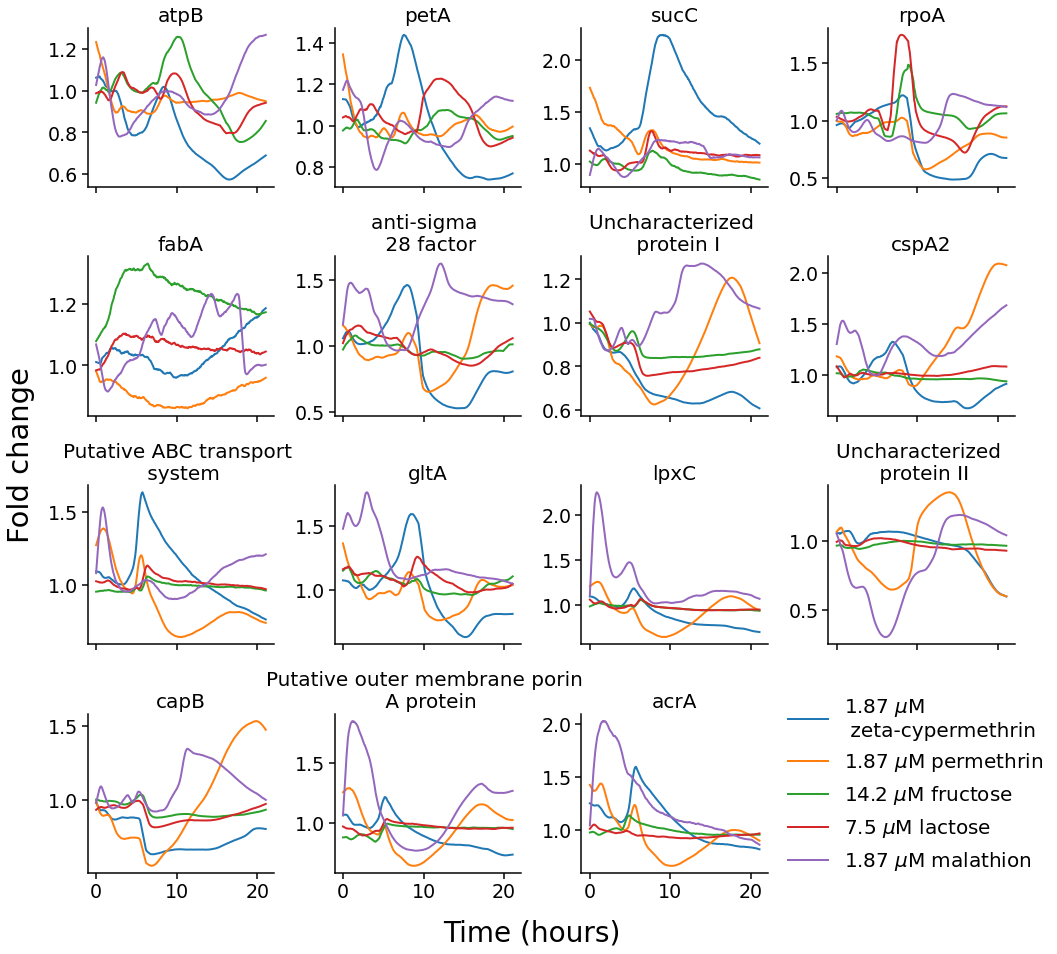

In [86]:
# going to use n_time_pts of the permethrin and zeta-cypermethrin dataset for malathion as well
# going to use n_time_pts of the fructose and lactose experiment 

savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/specificity_screens/specificity_time_series.pdf'

plt.rcParams.update({'font.size':19});
cond_short = ['zeta','perm','fructose','lactose']
fig, axs = plt.subplots(4,4,figsize=(14,13),sharex=True,sharey=False)
fig.delaxes(axs[-1,-1])
for ii, ax in enumerate(axs.reshape(-1)): 
    if ii < len(all_strains):
        ax.set_title(all_genes[ii],fontsize=20)
        for this_cond in cond_short:
            if this_cond != 'fructose' and this_cond != 'lactose':
                TSPAN = np.linspace(0,421*sampling_rate/60,421)
            else: 
                TSPAN = np.linspace(0,421*sampling_rate/60,421)
            ax.plot(TSPAN,savgol( fc[all_strains[ii]+'_'+this_cond][:421],15,1 ) )
        ax.plot(TSPAN,savgol( titr_fc_dict[all_strains[ii]][-2][:421],15,1 )) # plot mal
        ax.xaxis.set_tick_params(which='both', size=6, width=1.5 )
        ax.yaxis.set_tick_params(which='both', size=6, width=1.5 )
#         ax.set_ylim(0.2,2.4)
fig.legend(['1.87 $\mu$M \n zeta-cypermethrin' ,'1.87 $\mu$M permethrin',
            r'14.2 $\mu$M fructose', r'7.5 $\mu$M lactose', r'1.87 $\mu$M malathion'],
               frameon=False,fontsize=20,bbox_to_anchor=(1.025,0.26),ncol=1);
fig.text(0.5, -0.02, 'Time (hours)', ha='center',fontsize=28);
fig.text(-0.02, 0.5, 'Fold change', va='center', rotation='vertical',fontsize=29);
plt.tight_layout()

if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()

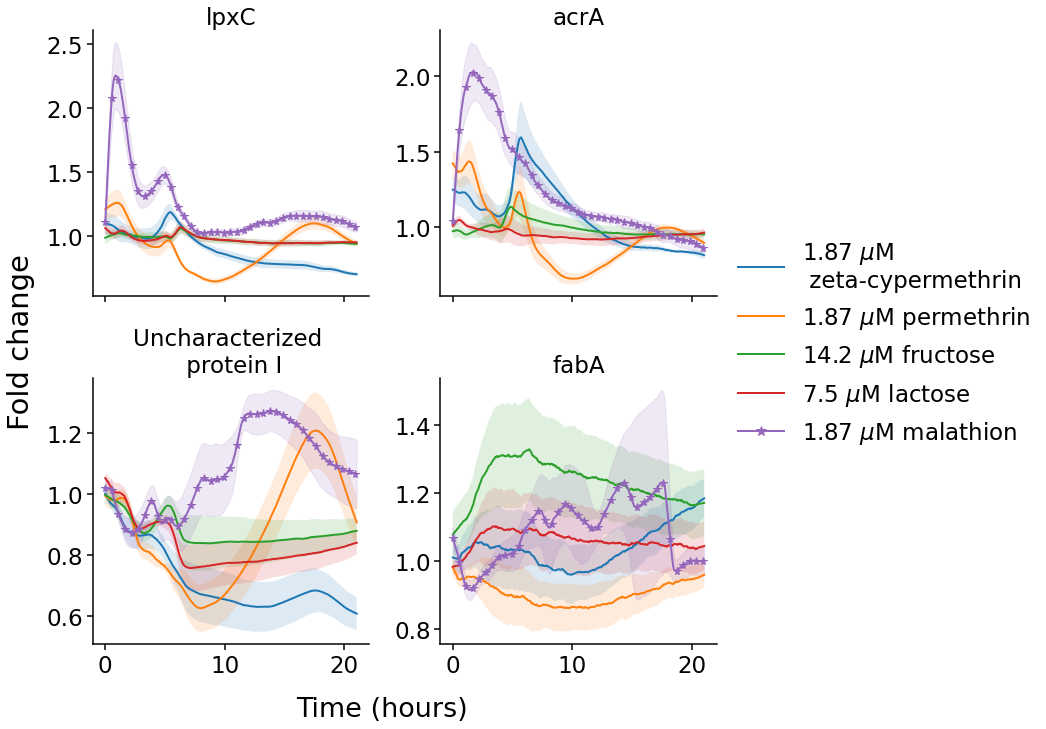

In [52]:
# going to use n_time_pts of the permethrin and zeta-cypermethrin dataset for malathion as well
# going to use n_time_pts of the fructose and lactose experiment 

savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig5/specificity_time_series_subset.pdf'

plt.rcParams.update({'font.size':23});
cond_short = ['zeta','perm','fructose','lactose']
fig, axs = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=False)
spec_tags = ['0953','1380','3761','1836']
spec_genes = ['lpxC','acrA','Uncharacterized \n protein I','fabA']
for ii, ax in enumerate(axs.reshape(-1)): 
    ax.set_title(spec_genes[ii],fontsize=23)
    for this_cond in cond_short:
        if this_cond != 'fructose' and this_cond != 'lactose':
            TSPAN = np.linspace(0,421*sampling_rate/60,421)
        else: 
            TSPAN = np.linspace(0,421*sampling_rate/60,421)
        ax.plot(TSPAN,savgol( fc[spec_tags[ii]+'_'+this_cond][:421],15,1 ) )
        ax.fill_between(TSPAN,savgol(fc[spec_tags[ii]+'_'+this_cond][:421]-fc_std[spec_tags[ii]+'_'+this_cond][:421],15,1 ),
                       savgol(fc[spec_tags[ii]+'_'+this_cond][:421]+fc_std[spec_tags[ii]+'_'+this_cond][:421],15,1 ),alpha=0.15)
    ax.plot(TSPAN,savgol( titr_fc_dict[spec_tags[ii]][-2][:421],15,1 )) # plot mal
    ax.plot(TSPAN[::11],savgol( titr_fc_dict[spec_tags[ii]][-2][:421],15,1 )[::11],'*',ms=8,c='tab:purple') # plot mal
    ax.fill_between(TSPAN,savgol(titr_fc_dict[spec_tags[ii]][-2][:421]-titr_fc_std_dict[spec_tags[ii]][-2][:421],15,1),
                    savgol(titr_fc_dict[spec_tags[ii]][-2][:421]+titr_fc_std_dict[spec_tags[ii]][-2][:421],15,1),
                    color='tab:purple',alpha=0.15)
    ax.xaxis.set_tick_params(which='both', size=6, width=1.5 )
    ax.yaxis.set_tick_params(which='both', size=6, width=1.5 )

plt.plot([],[],'-',c='tab:blue',label='1.87 $\mu$M \n zeta-cypermethrin')
plt.plot([],[],'-',c='tab:orange',label='1.87 $\mu$M permethrin')
plt.plot([],[],'-',c='tab:green',label=r'14.2 $\mu$M fructose')
plt.plot([],[],'-',c='tab:red',label= r'7.5 $\mu$M lactose')
plt.plot([],[],'*-',ms=11,c='tab:purple',label=r'1.87 $\mu$M malathion')
fig.legend(frameon=False,fontsize=23,bbox_to_anchor=(1.43,0.67),ncol=1);
fig.text(0.5, -0.02, 'Time (hours)', ha='center',fontsize=27);
fig.text(-0.02, 0.5, 'Fold change', va='center', rotation='vertical',fontsize=29);
plt.tight_layout()

if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()

In [134]:
corr_names = ['atpB','petA','sucC','rpoA','fabA','anti-sigma 28 factor','Uncharacterized \n protein I',
              'cspA2','Putative ABC \n transport system','gltA','lpxC','Uncharacterized \n protein II',
              'capB','Putative outer membrane \n porin A protein','acrA']

In [135]:
### plot correlations of each strain mal to same strain other treatment
# going to use n_time_pts of the fructose and lactose experiment for zeta, perm, and mal

corr = {'pearson':{},'spearman':{},'l2':{}}
cond_short = ['zeta','perm','fructose','lactose']
for strain in all_strains:  
    mal = titr_fc_dict[strain][-2][:421]
    corr['pearson'][strain] = {}
    corr['spearman'][strain] = {}
    corr['l2'][strain] = {}
    for this_cond in cond_short: 
        corr['pearson'][strain][this_cond] = sp.stats.pearsonr(mal,fc[strain+'_'+this_cond][:421])[0]
        corr['spearman'][strain][this_cond] = sp.stats.spearmanr(mal,fc[strain+'_'+this_cond][:421])[0]
        corr['l2'][strain][this_cond] = ( np.linalg.norm(mal - fc[strain+'_'+this_cond][:421]) / 
                                                                                np.linalg.norm(mal) )
        
pearson = pd.DataFrame(corr['pearson'])
pearson.columns = corr_names
pearson = pearson.set_index([['zeta-cypermethrin','permethrin','fructose','lactose']],drop=True)
pearson = pearson.T

spearman = pd.DataFrame(corr['spearman'])
spearman.columns = corr_names
spearman = spearman.set_index([['zeta-cypermethrin','permethrin','fructose','lactose']],drop=True)
spearman = spearman.T

dists = pd.DataFrame(corr['l2'])
dists.columns = corr_names
dists = dists.set_index([['zeta-cypermethrin','permethrin','fructose','lactose']],drop=True)
dists = dists.T

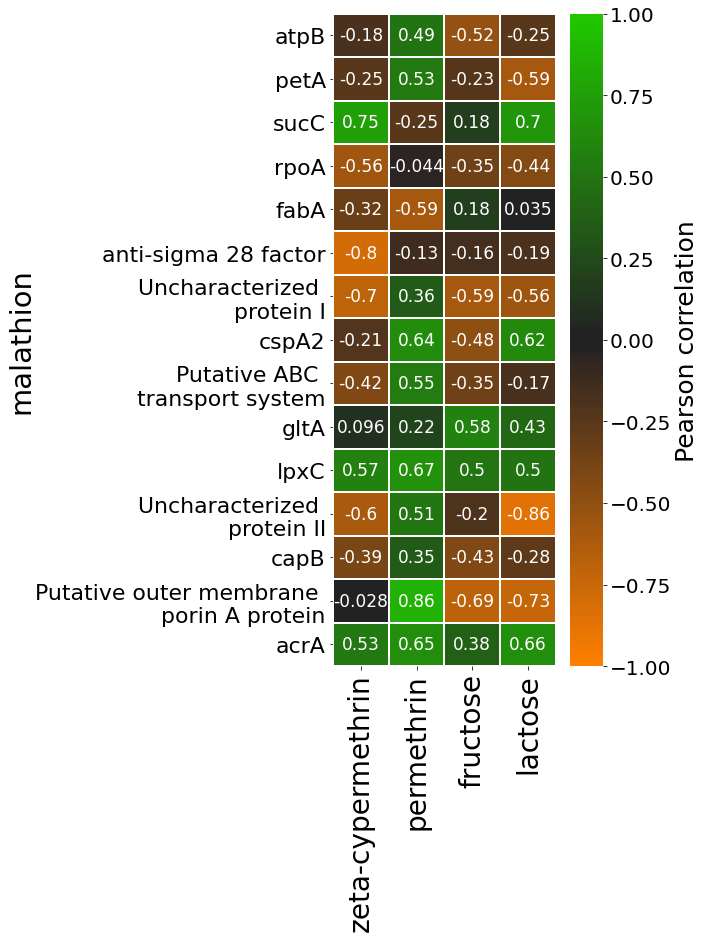

In [137]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig5/specificity_corr.pdf'b

plt.rcParams.update({'font.size':25});

# cmap = sns.diverging_palette(19, 235, as_cmap=True)
cmap = sns.diverging_palette(27, 120, s=140, l=70, sep=10, as_cmap=True, center='dark')
plt.figure(figsize=(5,12))
ax = sns.heatmap(pearson,cmap=cmap,cbar_kws={'label':'Pearson correlation'},linewidths=1,
                 annot=True,annot_kws={"size":17},center=0.0,vmin=-1,vmax=1)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(25)
plt.xticks(np.arange(0.5,4.5), ['zeta-cypermethrin','permethrin','fructose','lactose'],fontsize=28)
plt.yticks(np.arange(0.5,len(corr_names)+0.5), corr_names,fontsize=22)
plt.ylabel('malathion',fontsize=29,labelpad=0.1)
if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()


The overall lack of correlation (except for permethrin, which maybe is not surprising) indicates that the sensors we have extracted for malathion sensing provide a unique signature (at least in the small chemical space we have tested). 

Reading across the rows, we can see only lpxC has correlation greater than or equal to 0.5 for all inputs. this is due to the response of this strain being acute early, and no response later. Then all inputs are correlated for most time points. 

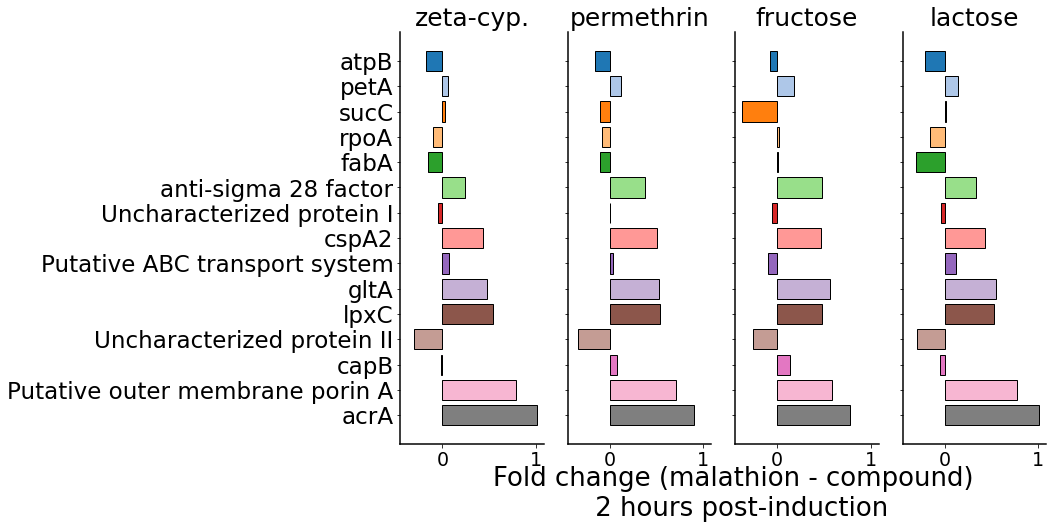

In [151]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig5/specificity_single_time.pdf'

which_time = 45 # 2 hours
cmap = matplotlib.cm.get_cmap('tab20')
fig,axs = plt.subplots(1,4,sharex=True,sharey=True,figsize=(15,7))
plt.setp(axs, yticks=range(len(all_strains)), yticklabels=hm_gene_names[::-1])
titles = ['zeta-cyp.','permethrin','fructose','lactose']
conds = ['zeta','perm','fructose','lactose']
for ii, ax in enumerate(axs.reshape(-1)):
    for jj,strain in enumerate(range(len(all_strains))):
        strain = all_strains[jj]
        ax.barh(14-jj,titr_fc_dict[strain][-2][which_time] - fc[strain+'_'+conds[ii-1]][which_time],
                color=cmap(jj),linewidth=1,edgecolor='k')
#     ax.grid(linestyle='-',linewidth=1)
    ax.set_yticklabels(hm_gene_names[::-1],fontsize=23)
    ax.set_title(titles[ii],fontsize=25)
fig.text(0.695, -0.05, 'Fold change (malathion - compound) \n 2 hours post-induction',
         ha='center',fontsize=26);
plt.tight_layout()
if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()

Plot OD

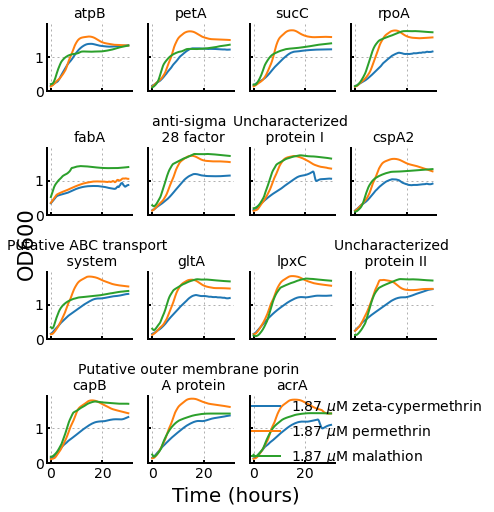

In [34]:
cond_short = ['zeta','perm']
fig, axs = plt.subplots(4,4,figsize=(6,7),sharex=True,sharey=True)
fig.delaxes(axs[-1,-1])
for ii, ax in enumerate(axs.reshape(-1)): 
    if ii < len(all_strains):
        ax.set_title(all_genes[ii],fontsize=14)
        for this_cond in cond_short: 
            ax.plot(tspan,savgol( mean_od[all_strains[ii]+'_'+this_cond],15,1 ) )
        ax.plot(tspan,savgol( od_mean_dict[all_strains[ii]][-2][:601],15,1 ))
        ax.grid(linestyle=':',linewidth=1,dashes=(2,3))
        for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
            ax.spines[side].set_linewidth(2)    
        ax.xaxis.set_tick_params(which='both', size=3, width=2, direction='in')
        ax.yaxis.set_tick_params(which='both', size=3, width=2, direction='in')
fig.legend(['1.87 $\mu$M zeta-cypermethrin' ,'1.87 $\mu$M permethrin',r'1.87 $\mu$M malathion'],
               frameon=False,fontsize=14,bbox_to_anchor=(1.1,0.22),ncol=1);
fig.text(0.5, -0.01, 'Time (hours)', ha='center',fontsize=20);
fig.text(-0.005, 0.5, 'OD600', va='center', rotation='vertical',fontsize=21);
plt.tight_layout()
plt.show()

#### Mixed inducer experiments with anti-sigma 28 factor and lpxC

In [132]:
sampling_rate = 3 # minutes
fn = 'data/malathion-reporter-plate-reader/specificity_screen_ah_h1_09.28.22.txt'
nR = 8
nC = 12
od,gfp,gfpn,tspan = get_data(fn,nR,nC,sampling_rate)

# metadata and load data
conds = ['control','mal','perm','zeta','mal+perm','mal+zeta']
inds = ['B','C','D','E']
cols = [2,3,4,5,6,7,8,9,10]
xls = pd.ExcelFile(ddir+'plate_layouts.xlsx')
plate_df = pd.read_excel(xls,'h1_specificity_09.28.22',header=None)
plate_df = plate_df.set_index([inds])
plate_df.columns = cols

mean_od_5, mean_gfpn_5, fc_5 = tidy_specificity_data(plate_df,od,gfpn,
                                 treat_list=['control','mal','perm','zeta','mal+perm','mal+zeta'])


In [133]:
pearson['mal+zeta'] = [np.nan]*len(pearson)
pearson['mal+perm'] = [np.nan]*len(pearson)

mal = titr_fc_dict['0953'][-2][:601]
# pearson['mal+zeta']['anti-sigma 28 factor']=  sp.stats.spearmanr(fc_5['4736_mal'],fc_5['4736_mal+zeta'])[0]
# pearson['mal+perm']['anti-sigma 28 factor']=  sp.stats.spearmanr(fc_5['4736_mal'],fc_5['4736_mal+perm'])[0]
pearson['mal+zeta']['anti-sigma 28 factor']=  sp.stats.spearmanr(mal,fc_5['4736_mal+zeta'])[0]
pearson['mal+perm']['anti-sigma 28 factor']=  sp.stats.spearmanr(mal,fc_5['4736_mal+perm'])[0]

mal = titr_fc_dict['0953'][-2][:601]
# pearson['mal+zeta']['lpxC'] = sp.stats.spearmanr(fc_5['0953_mal'],fc_5['0953_mal+zeta'])[0]
# pearson['mal+perm']['lpxC'] = sp.stats.spearmanr(fc_5['0953_mal'],fc_5['0953_mal+perm'])[0]
pearson['mal+zeta']['lpxC'] = sp.stats.spearmanr(mal,fc_5['0953_mal+zeta'])[0]
pearson['mal+perm']['lpxC'] = sp.stats.spearmanr(mal,fc_5['0953_mal+perm'])[0]

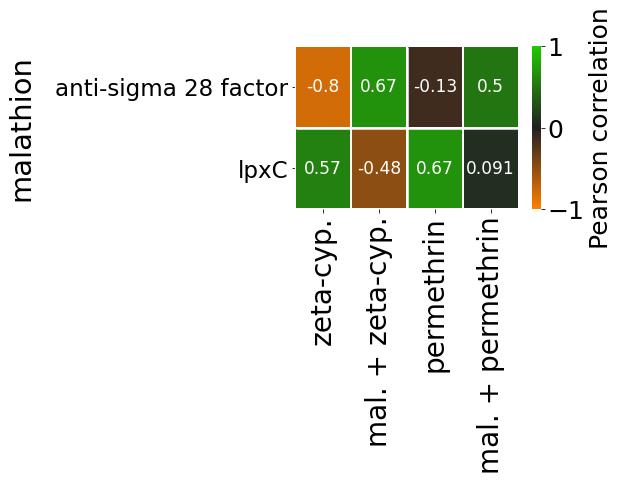

In [134]:
savefig = False

figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig5/specificity_double_corr.pdf'

cmap = sns.diverging_palette(27, 120, s=140, l=70, sep=10, as_cmap=True, center='dark')
plt.figure(figsize=(5,3))
ax = sns.heatmap(pearson[['zeta-cypermethrin','mal+zeta','permethrin',
                          'mal+perm']].loc[['anti-sigma 28 factor','lpxC']],cmap=cmap,vmin=-1,vmax=1,
                          cbar_kws={'label':'Pearson correlation'},center=0.0,linewidths=1,
                          annot=True,annot_kws={"size":17})
ax.hlines(1,0.01,3.99,color='white',lw=2.5)
ax.vlines(2,0.01,1.99,color='white',lw=2.5)
bar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(25)
plt.xticks(np.arange(0.5,4.5), ['zeta-cyp.','mal. + zeta-cyp.','permethrin','mal. + permethrin'],fontsize=28,rotation=90)
plt.yticks(np.arange(0.5,2.5), ['anti-sigma 28 factor','lpxC'],fontsize=23)
plt.ylabel('malathion',fontsize=29,labelpad=20)
if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()

### Pooled reporters

In [5]:
fn = 'data/malathion-reporter-plate-reader/pooled_reporters_10.16.22.txt'
od,gfp,gfpn,tspan = get_data(fn,8,12,3)

In [6]:
conds = [0,1,2,3] # µL of 5% spectracide
gfpn_mean = {}
gfpn_std = {}
for ii in range(1,5):
    r1 = gfpn['D'+str((ii-1)*3+1)].reshape(-1)
    r2 = gfpn['D'+str((ii-1)*3+2)].reshape(-1)
    r3 = gfpn['D'+str((ii-1)*3+3)].reshape(-1)
    gfpn_mean[ii-1] = ( r1 + r2 + r3)/3
    gfpn_std[ii-1] =  np.sqrt(((r1 - gfpn_mean[ii-1])**2 + (r2 - gfpn_mean[ii-1])**2 + 
                               (r3 - gfpn_mean[ii-1])**2)/3)
    
fc = {}

In [13]:
fc = {}
fc[0] = gfpn_mean[1]/gfpn_mean[0]
fc[1] = gfpn_mean[2]/gfpn_mean[0]
fc[2] = gfpn_mean[3]/gfpn_mean[0]

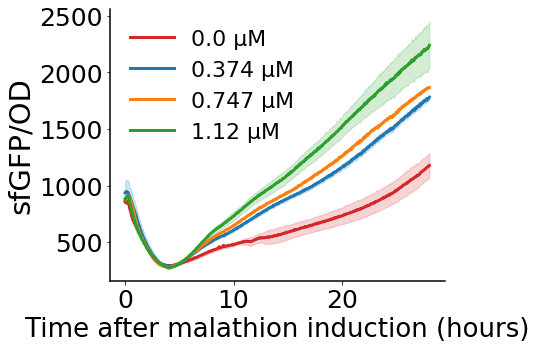

In [7]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig6/pooled_reporters_ts.pdf'

colors = ['tab:red','tab:blue','tab:orange','tab:green']
labels = ['0.0 µM', '0.374 µM', '0.747 µM','1.12 µM']
plt.figure(figsize=(6,5))
for ii in range(len(conds)):
    plt.plot(tspan,gfpn_mean[ii],lw=3,label=labels[ii],color=colors[ii])
    plt.fill_between(tspan,gfpn_mean[ii]-gfpn_std[ii],gfpn_mean[ii]+gfpn_std[ii],alpha=0.2,color=colors[ii])
plt.legend(frameon=False,fontsize=22)
plt.xlabel('Time after malathion induction (hours)',fontsize=26)
plt.ylabel('sfGFP/OD',fontsize=29)
if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()


In [11]:
hours = 22.25
hour_ind = int(hours*60/3)
pooled_fc = [gfpn_mean[1][hour_ind]/gfpn_mean[0][hour_ind],gfpn_mean[2][hour_ind]/gfpn_mean[0][hour_ind], gfpn_mean[3][hour_ind]/gfpn_mean[0][hour_ind]]
pooled_fc_std = [pooled_fc[0] * np.sqrt( (gfpn_std[1][hour_ind]/gfpn_mean[1][hour_ind])**2 + (gfpn_std[0][hour_ind]/gfpn_mean[0][hour_ind])**2 ),
              pooled_fc[1] * np.sqrt( (gfpn_std[2][hour_ind]/gfpn_mean[2][hour_ind])**2 + (gfpn_std[0][hour_ind]/gfpn_mean[0][hour_ind])**2 ),
              pooled_fc[2] * np.sqrt( (gfpn_std[3][hour_ind]/gfpn_mean[3][hour_ind])**2 + (gfpn_std[0][hour_ind]/gfpn_mean[0][hour_ind])**2 )]

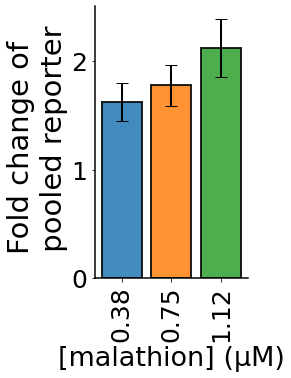

In [12]:
savefig = False
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/fig6/pooled_reporters_fc.pdf'

plt.figure(figsize=(2.75,5))
plt.bar([0.38,0.75,1.12],pooled_fc,yerr=pooled_fc_std,capsize=6,width=0.3,color=['tab:blue','tab:orange','tab:green'],alpha=0.85,edgecolor='k',linewidth=2)
plt.xticks(ticks=[0.38,0.75,1.12],labels=[0.38,0.75,1.12],rotation=90)
plt.xlabel('[malathion] (µM)',fontsize=27); plt.ylabel('Fold change of \n pooled reporter',fontsize=29);
if savefig: 
    plt.savefig(figDir,transparent=True,bbox_inches='tight',dpi=300)
plt.show()

Text(0, 0.5, 'Fold change')

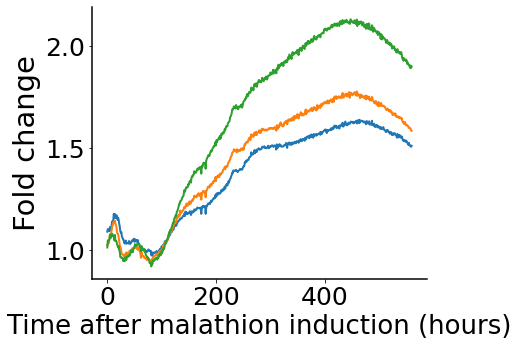

In [33]:
plt.figure(figsize=(6,5))
for ii in range(0,3):
    plt.plot(fc[ii])
plt.xlabel('Time after malathion induction (hours)',fontsize=26)
plt.ylabel('Fold change',fontsize=29)